TỐI ƯU HÓA DANH MỤC BẰNG LÝ THUYẾT MORDERN PORTFOLIO THEORY VÀ DỰ ĐOÁN GIÁ BẰNG MONTE CARLO CŨNG NHƯ STRESS TESTING VÀ BACKTESTING

PHẦN 1: IMPORT THƯ VIỆN, TẢI DỮ LIỆU VÀ XỬ LÝ DỮ LIỆU

In [1]:
from vnstock import Vnstock
from vnstock import Listing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.stats as stats
from tqdm import tqdm 
from datetime import datetime
import plotly.graph_objects as go

Phiên bản Vnai 2.1.7 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.4

In [2]:
# Liệt kê các cổ phiếu của VN30
listing = Listing(source='VCI')
symbols = listing.symbols_by_group('VN30')

# Tạo dictionary lưu dữ liệu
data = {}

# Tải dữ liệu từng mã
for symbol in tqdm(symbols):
    try:
        stock = Vnstock().stock(symbol=symbol, source='VCI')
        df = stock.quote.history(start='2019-01-01', end='2024-12-31', interval='1D')
        df['time'] = pd.to_datetime(df['time'])  # Chuyển về datetime để chuẩn
        df.set_index('time', inplace=True)       # Dùng cột thời gian làm index
        df = df[['open', 'high', 'low', 'close', 'volume']]
        df.columns = [f'{symbol}_{col.capitalize()}' for col in df.columns]  # Đổi tên cột
        data[symbol] = df
    except Exception as e:
        print(f"Lỗi khi lấy dữ liệu {symbol}: {e}")

# Gộp tất cả các DataFrame thành một bảng lớn (merge theo chỉ số thời gian)
merged_df = pd.concat(data.values(), axis=1, join='outer')

# Reset index để cột Date là cột đầu tiên
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'time': 'Date'}, inplace=True)

# Xuất ra file CSV
merged_df.to_csv("stocks_pivoted.csv", index=False)

100%|██████████| 30/30 [01:00<00:00,  2.02s/it]


In [3]:
df = pd.read_csv("stocks_pivoted.csv", parse_dates=['Date'])
# Đặt Date làm index
df.set_index('Date', inplace=True)
# Xử lý các giá trị bị thiếu 
print(df.isna().sum().sum()) # in ra tổng số lượng giá trị Na bị thiếu 

2960


In [4]:
# Xử lý các giá trị bị thiếu và fill Na
df_filled = df.ffill()
df_filled = df_filled.bfill()  
df_filled.isna().sum().sum()

# Trích xuất giá đóng cửa 
close_df = df_filled.filter(regex='_Close$')
close_df.to_csv('close_prices.csv', index=True)

In [5]:
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df

,ACB_Close,BCM_Close,BID_Close,BVH_Close,CTG_Close,FPT_Close,GAS_Close,GVR_Close,HDB_Close,HPG_Close,...,TCB_Close,TPB_Close,VCB_Close,VHM_Close,VIB_Close,VIC_Close,VJC_Close,VNM_Close,VPB_Close,VRE_Close
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.48,21.95,18.48,76.33,12.68,15.12,54.77,8.32,7.22,8.17,...,12.41,5.92,23.11,53.51,3.42,89.25,115.98,76.36,6.33,27.97
2019-01-03,6.24,20.12,17.66,76.50,12.08,14.97,53.44,8.24,7.21,7.82,...,12.12,5.79,23.11,53.30,3.36,89.16,115.19,75.69,6.20,26.91
2019-01-04,6.28,20.76,17.41,75.99,12.24,15.08,53.32,8.24,7.43,7.88,...,12.10,5.77,23.45,53.88,3.38,89.42,114.00,76.98,6.18,26.71
2019-01-07,6.37,20.67,17.82,75.99,12.11,15.34,54.45,7.88,7.40,7.78,...,12.17,5.83,23.54,54.02,3.40,89.78,114.99,80.67,6.28,27.10
2019-01-08,6.33,20.76,17.66,75.64,11.94,15.41,55.71,8.06,7.30,7.65,...,12.17,5.84,23.71,54.02,3.42,89.78,114.00,80.06,6.25,26.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,21.26,69.30,38.65,53.60,38.20,149.52,68.40,31.10,23.90,22.62,...,24.45,15.29,61.81,40.60,16.20,40.65,102.00,61.71,18.69,17.30
2024-12-26,21.35,69.70,39.00,52.60,38.20,148.53,68.50,30.90,24.15,22.50,...,24.35,15.43,61.61,40.65,16.66,40.65,101.50,61.62,18.74,17.15
2024-12-27,21.35,69.80,39.15,52.30,38.80,148.33,68.50,30.70,24.95,22.37,...,24.60,15.61,61.67,40.35,16.92,40.55,101.20,61.62,18.74,17.15


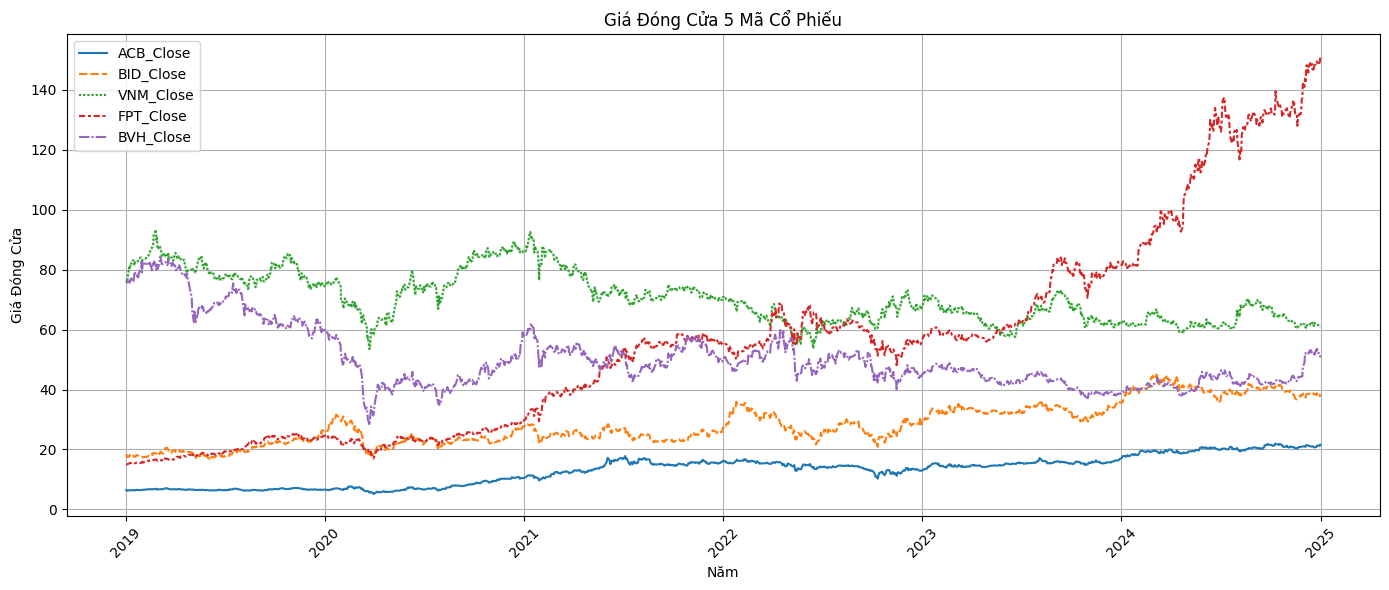

In [6]:
# Chọn ra 5 mã cổ phiếu đại diện hiển thị giá đóng cửa
selected_symbols = ['ACB_Close', 'BID_Close', 'VNM_Close', 'FPT_Close', 'BVH_Close', 'VNM_Close']

# Biểu đồ đường
plt.figure(figsize=(14, 6))
sns.lineplot(data=df[selected_symbols])
plt.title('Giá Đóng Cửa 5 Mã Cổ Phiếu')
plt.xlabel('Năm')
plt.ylabel('Giá Đóng Cửa')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

PHẦN 2: TÍNH TOÁN CÁC THAM SỐ VÀ HIỂN THỊ MA TRẬN TƯƠNG QUAN CỦA DANH MỤC

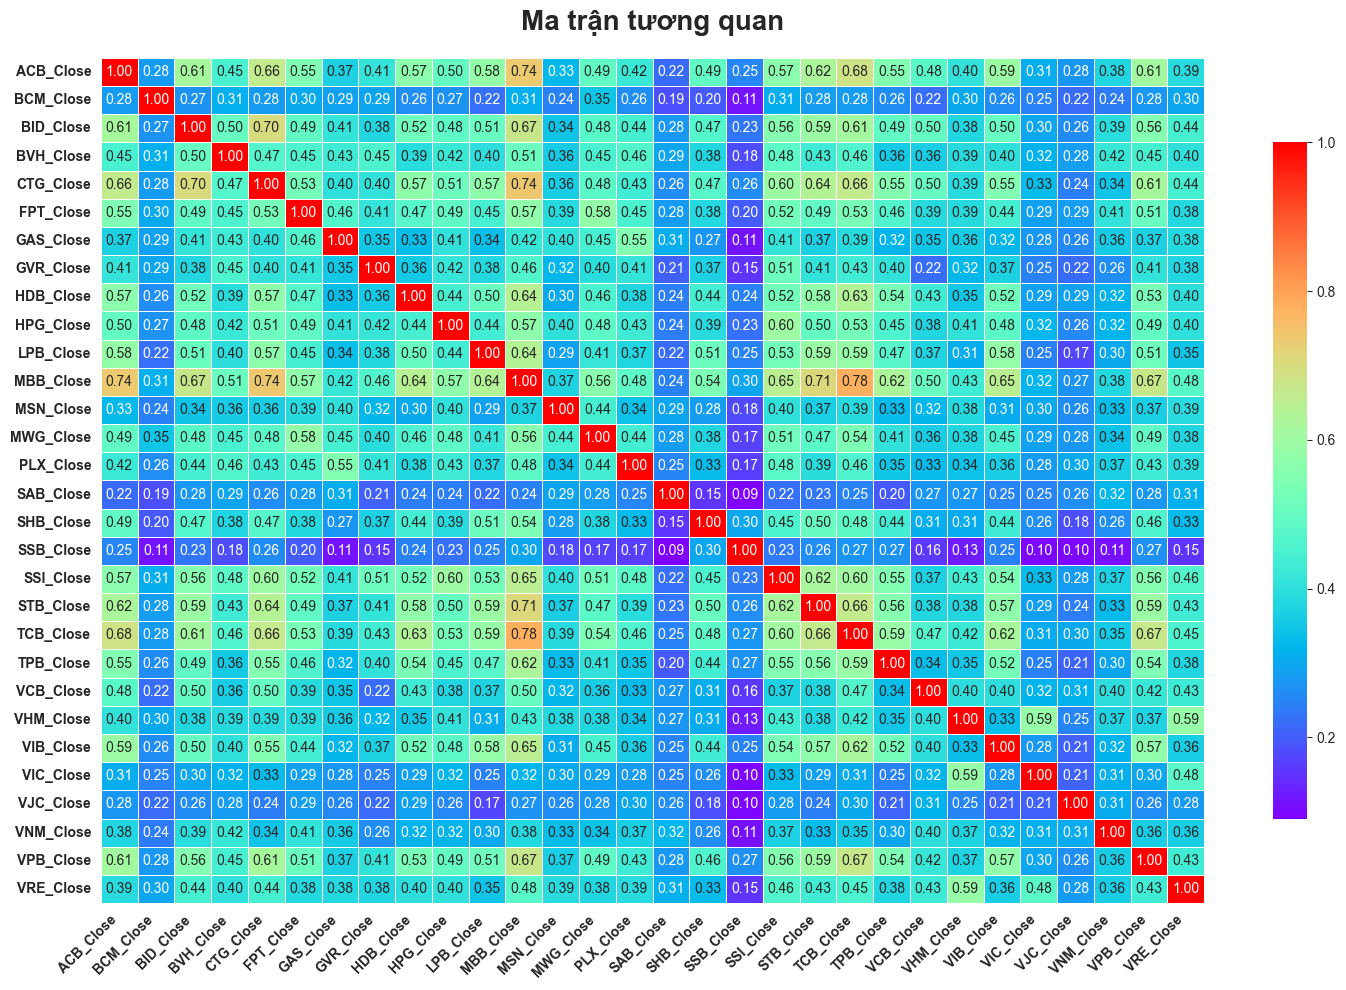

In [7]:
# Tính toán lợi suất hàng ngày
daily_returns = np.log(df/df.shift(1)).dropna()
# Tính toán ma trận tương quan
correlation_matrix = daily_returns.corr()

# Trực quan hóa ma trận tương quan
sns.set_style("whitegrid")
plt.figure(figsize=(15,10), dpi=100, facecolor='w', edgecolor='k')    
corr_matrix = sns.heatmap(correlation_matrix, cmap="rainbow", annot=True, fmt=".2f",
                         linewidths=0.5, linecolor='white',
                         annot_kws={"size": 10}, cbar_kws={"shrink": 0.8})

plt.title("Ma trận tương quan", fontsize=20, pad=20, fontweight='bold')

plt.xticks(fontsize=10, rotation=45, ha='right', fontweight='bold')
plt.yticks(fontsize=10, rotation=0, fontweight='bold')
plt.tight_layout()

plt.show()

In [8]:
correlation_matrix.to_csv('correlation_matrix.csv')

In [9]:
# Loại bỏ các cặp tài sản có tương quan lớn hơn 0.7

def load_data(close_prices_path, correlation_matrix_path):
   
    try:
        close_prices = pd.read_csv(close_prices_path, index_col=0)
        correlation_matrix = pd.read_csv(correlation_matrix_path, index_col=0)
        return close_prices, correlation_matrix
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def analyze_and_drop_highly_correlated(correlation_matrix, threshold=0.7):
    
    to_drop = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                to_drop.add(correlation_matrix.columns[j])
    
    return list(to_drop)

def create_final_dataframe(close_prices, to_drop):
    
    close_prices_final = close_prices.drop(columns=to_drop)
    return close_prices_final

def main():
    close_prices_path = "close_prices.csv"
    correlation_matrix_path = "correlation_matrix.csv"
    
    # Truyền dữ liệu
    close_prices, correlation_matrix = load_data(close_prices_path, correlation_matrix_path)
    
    # Phân tích và loại bỏ các cột có tương quan cao
    to_drop = analyze_and_drop_highly_correlated(correlation_matrix, threshold=0.7)
    
    # Tạo DataFrame cuối cùng với các cột đã loại bỏ
    close_prices_final = create_final_dataframe(close_prices, to_drop)
    
    # Chỉ giữ lại các cột có giá trị không bị thiếu
    close_prices_final.to_csv("close_prices_final.csv", index=True)
    print("Final DataFrame saved to close_prices_final.csv")

if __name__ == "__main__":
    main()

Final DataFrame saved to close_prices_final.csv


In [10]:
dataframes = pd.read_csv("close_prices_final.csv", parse_dates=['Date']) 
dataframes.set_index('Date', inplace=True)
dataframes

,ACB_Close,BCM_Close,BID_Close,BVH_Close,CTG_Close,FPT_Close,GAS_Close,GVR_Close,HDB_Close,HPG_Close,...,SSI_Close,TPB_Close,VCB_Close,VHM_Close,VIB_Close,VIC_Close,VJC_Close,VNM_Close,VPB_Close,VRE_Close
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6.48,21.95,18.48,76.33,12.68,15.12,54.77,8.32,7.22,8.17,...,9.38,5.92,23.11,53.51,3.42,89.25,115.98,76.36,6.33,27.97
2019-01-03,6.24,20.12,17.66,76.50,12.08,14.97,53.44,8.24,7.21,7.82,...,9.20,5.79,23.11,53.30,3.36,89.16,115.19,75.69,6.20,26.91
2019-01-04,6.28,20.76,17.41,75.99,12.24,15.08,53.32,8.24,7.43,7.88,...,9.20,5.77,23.45,53.88,3.38,89.42,114.00,76.98,6.18,26.71
2019-01-07,6.37,20.67,17.82,75.99,12.11,15.34,54.45,7.88,7.40,7.78,...,9.22,5.83,23.54,54.02,3.40,89.78,114.99,80.67,6.28,27.10
2019-01-08,6.33,20.76,17.66,75.64,11.94,15.41,55.71,8.06,7.30,7.65,...,9.09,5.84,23.71,54.02,3.42,89.78,114.00,80.06,6.25,26.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,21.26,69.30,38.65,53.60,38.20,149.52,68.40,31.10,23.90,22.62,...,26.55,15.29,61.81,40.60,16.20,40.65,102.00,61.71,18.69,17.30
2024-12-26,21.35,69.70,39.00,52.60,38.20,148.53,68.50,30.90,24.15,22.50,...,26.35,15.43,61.61,40.65,16.66,40.65,101.50,61.62,18.74,17.15
2024-12-27,21.35,69.80,39.15,52.30,38.80,148.33,68.50,30.70,24.95,22.37,...,26.60,15.61,61.67,40.35,16.92,40.55,101.20,61.62,18.74,17.15


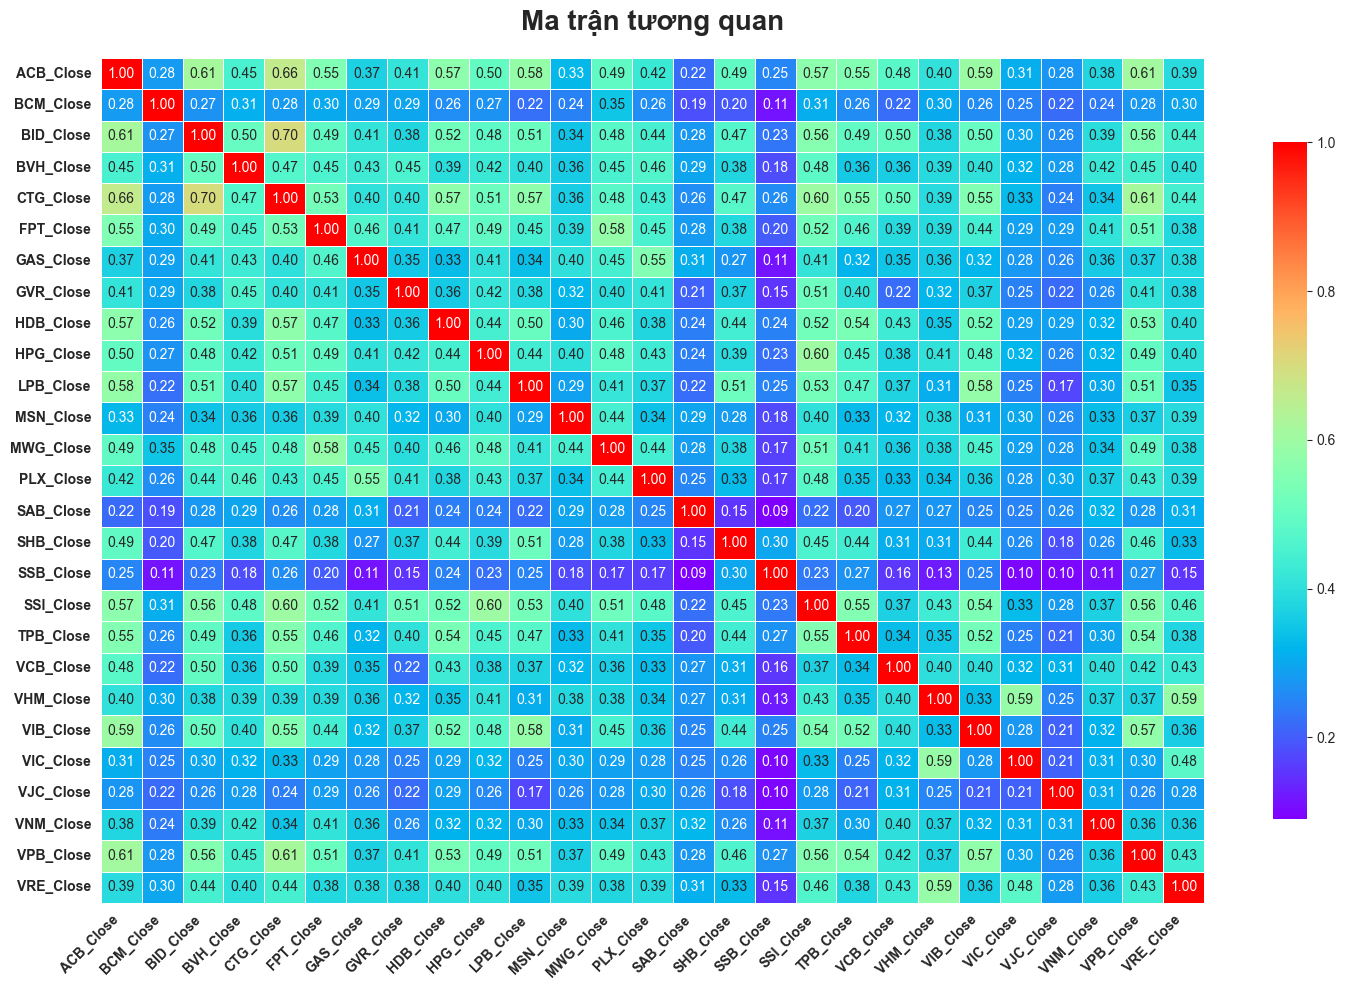

In [11]:
daily_return = np.log(dataframes/dataframes.shift(1)).dropna()

cor_matrix = daily_return.corr()
# Trực quan hóa ma trận tương quan
sns.set_style("whitegrid")
plt.figure(figsize=(15,10), dpi=100, facecolor='w', edgecolor='k')    
corr_matrix = sns.heatmap(cor_matrix, cmap="rainbow", annot=True, fmt=".2f",
                         linewidths=0.5, linecolor='white',
                         annot_kws={"size": 10}, cbar_kws={"shrink": 0.8})

plt.title("Ma trận tương quan", fontsize=20, pad=20, fontweight='bold')

plt.xticks(fontsize=10, rotation=45, ha='right', fontweight='bold')
plt.yticks(fontsize=10, rotation=0, fontweight='bold')
plt.tight_layout()

plt.show()

PHẦN 3: TÍNH TOÁN VÀ THỂ HIỆN LỢI NHUẬN HẰNG NĂM CŨNG NHƯ RỦI RO CỦA TỪNG MÃ VÀ KIỂM TRA PHÂN PHỐI CHUẨN CỦA LỢI NHUẬN HẰNG NGÀY

In [12]:
# Tính lợi nhuận hàng năm
periods_per_year = 252
annualized_returns = (1 + daily_return.mean()) ** periods_per_year - 1

# Độ biến động hằng năm
annualized_volatility = daily_return.std() * np.sqrt(periods_per_year)

# Giả định lái suất phi rủi ro là 3%/năm
risk_free_rate = 0.03

# Tính toán mức sinh lời vượt trội
excess_returns = daily_return - risk_free_rate / periods_per_year

# Tính Sharpe Ratio
sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(periods_per_year)

results = pd.DataFrame({
    'Lợi nhuận hằng năm': annualized_returns,
    'Rủi ro hằng năm': annualized_volatility,
    'Tỉ số Sharpe': sharpe_ratio
})
results

,Lợi nhuận hằng năm,Rủi ro hằng năm,Tỉ số Sharpe
ACB_Close,0.223860,0.281533,0.611262
BCM_Close,0.217787,0.389069,0.429517
BID_Close,0.126551,0.328795,0.271260
BVH_Close,-0.066478,0.324475,-0.304434
CTG_Close,0.201486,0.336151,0.457014
FPT_Close,0.472255,0.266162,1.341634
GAS_Close,0.037297,0.306721,0.021585
GVR_Close,0.242923,0.462806,0.405266
HDB_Close,0.236196,0.310283,0.586974
HPG_Close,0.183018,0.340181,0.406032


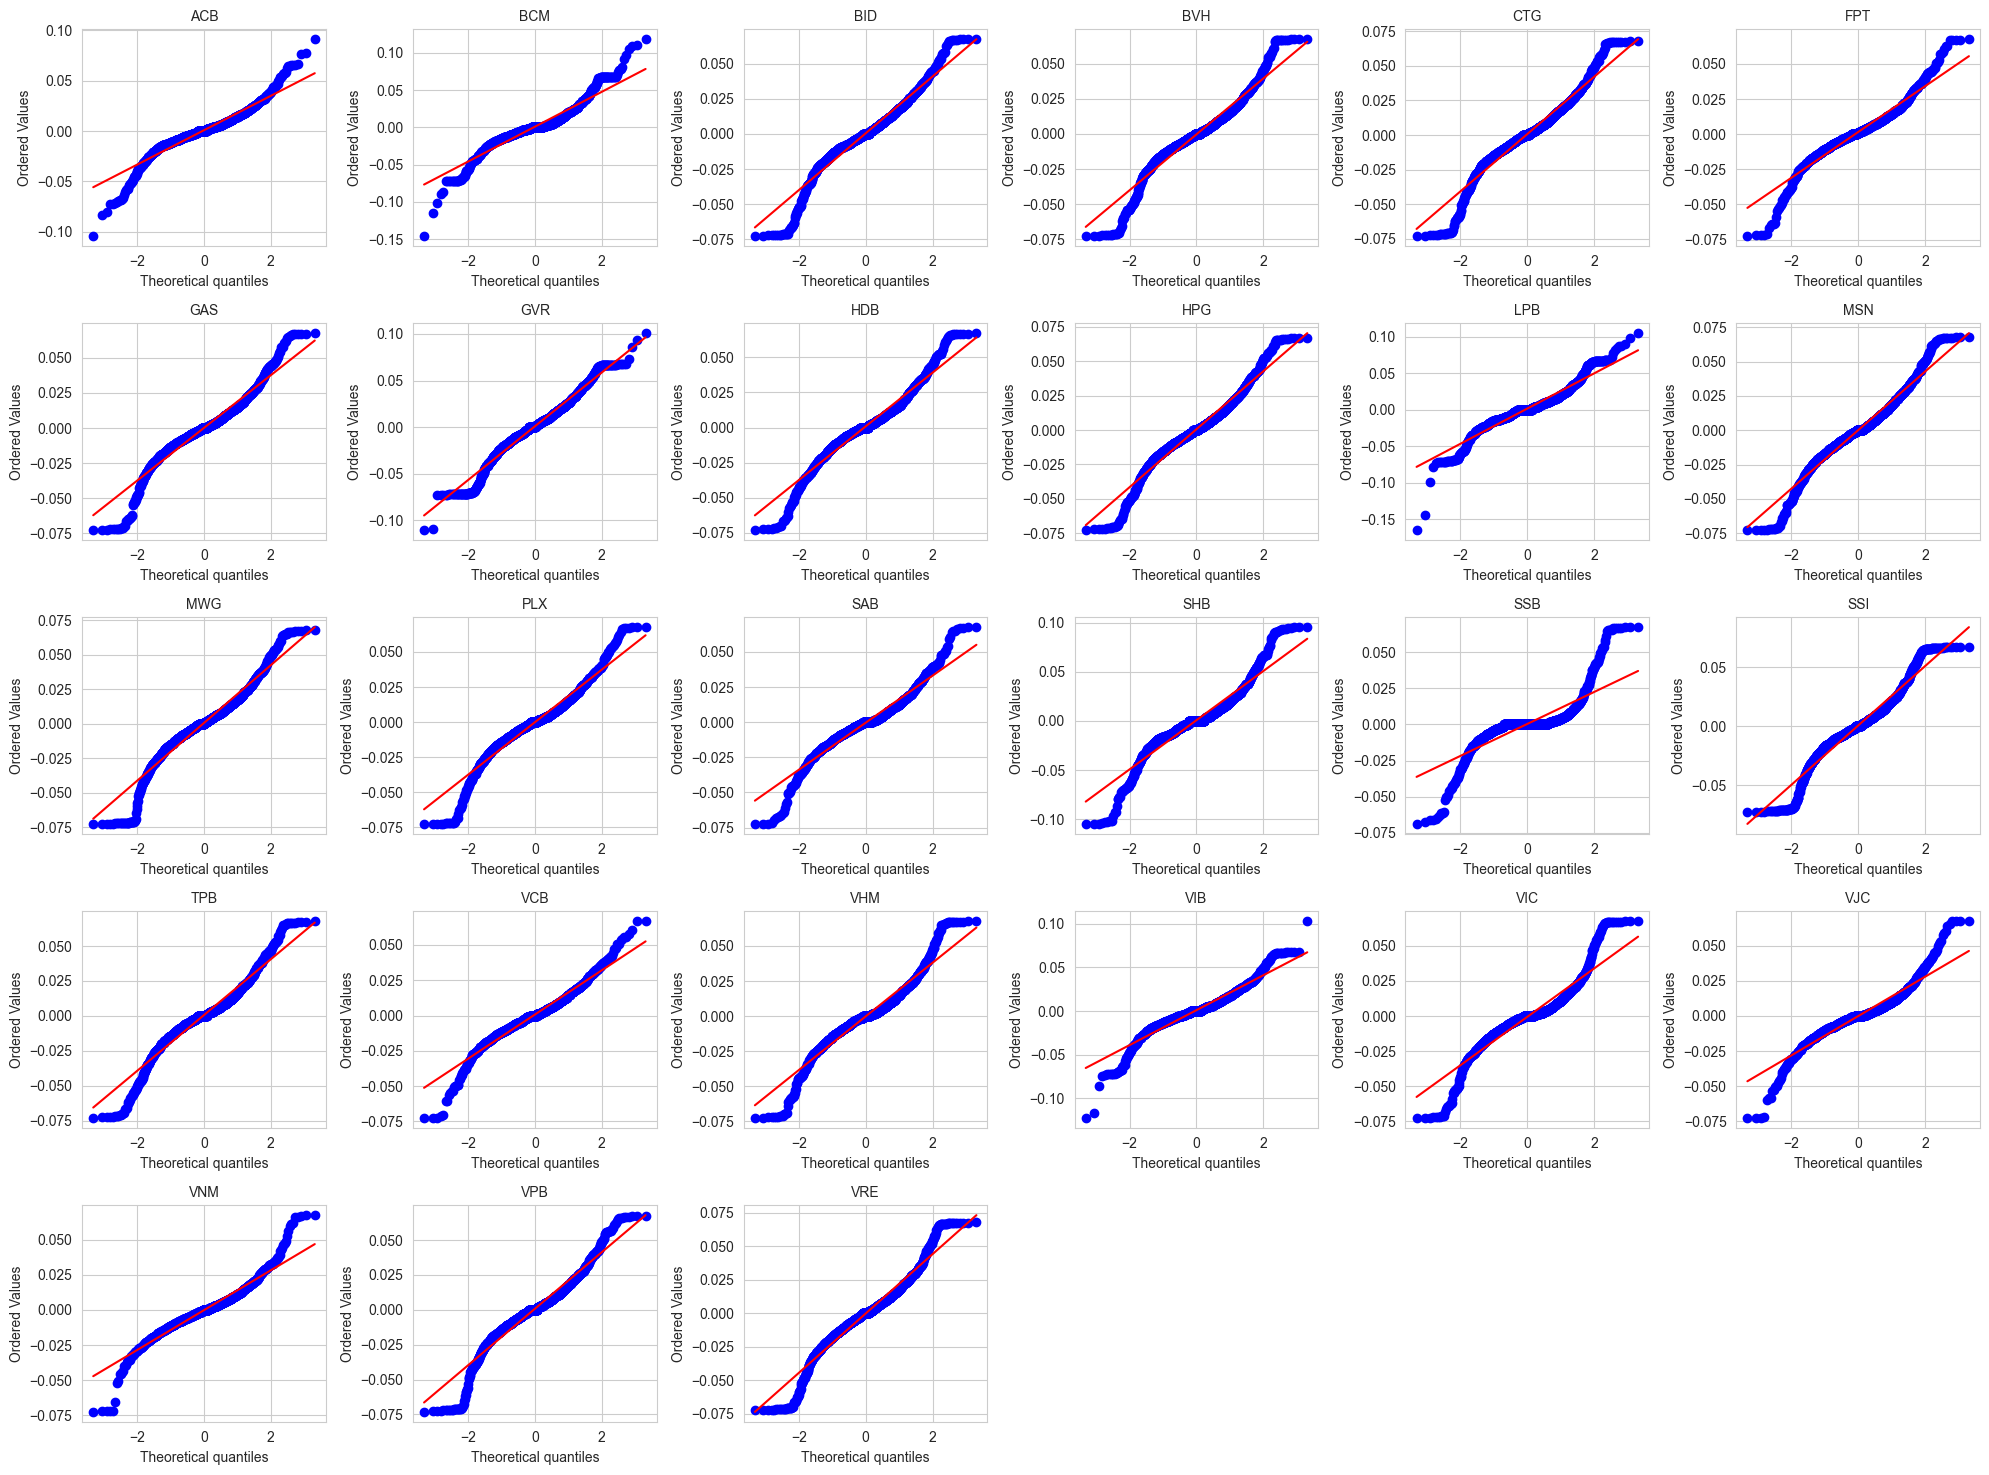

In [13]:
# Vẽ biểu đồ Q-Q plot cho từng mã cổ phiếu
# Kiểm tra xen phân phối chuẩn của lợi suất hàng ngày
symbols = daily_return.columns.tolist()
n_stocks = len(symbols)
n_cols = 6
n_rows = 5
n_plots = min(n_stocks, n_cols * n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
fig.suptitle('', fontsize=18, fontweight='bold', y=0.92)

# Vẽ từng Q-Q plot
for i in range(n_plots):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    stats.probplot(daily_returns[symbols[i]], dist="norm", plot=ax)
    ax.set_title(symbols[i].replace('_Close', ''), fontsize=10)

# Tắt subplot thừa nếu số mã < 30
for j in range(n_plots, n_cols * n_rows):
    row = j // n_cols
    col = j % n_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

PHẦN 4: TỐI ƯU HÓA DANH MỤC ĐẦU TƯ VÀ TRỰC QUAN HÓA DANH MỤC MAX SHARPE RATIO VÀ MIN VOLATILITY

In [14]:
# Tải dữ liệu
dataframes = pd.read_csv("close_prices_final.csv", parse_dates=['Date'])
dataframes.set_index('Date', inplace=True)

# Tính lợi nhuận hằng ngày bằng phương pháp log để giảm đi phần chênh lệch
daily_returns = np.log(dataframes/dataframes.shift(1)).dropna()

# Tính lợi nhuận trung bình và ma trận hiệp phương sai 
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Giả định lái suất phi rủi ro, số kỳ trong năm và số lượng tài sản
risk_free_rate = 0.03
periods_per_year = 252
num_assets = len(mean_returns)

# Đặt tỷ trọng là tỷ trọng ngẫu nhiên giữa các loại tài sản và đặt tổng tỷ trọng phải bằng 1 
weights = np.random.random(num_assets)
weights /= np.sum(weights)

In [15]:
# Xác định hàm tính hiệu suất danh mục đầu tư, độ biến động và Sharpe Ratio
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate, periods_per_year):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# In ra kết quả từ các tham số của hàm
portfolio_return, portfolio_volatility, sharpe_ratio = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate, periods_per_year)
print(f"Lợi nhuận của danh ngh mục đầu tư: {portfolio_return:.2%}")
print(f"Độ biến động của danh mục đầu tư: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio của danh mục đầu tư: {sharpe_ratio:.2f}")

Lợi nhuận của danh ngh mục đầu tư: 10.60%
Độ biến động của danh mục đầu tư: 20.41%
Sharpe Ratio của danh mục đầu tư: 0.37


In [16]:
# Tính Sharpe Ratio âm để sử dụng hàm minimize để giảm thiểu Sharpe âm, cũng như nó sẽ là tối đa cho Sharpe dương
def calc_neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Tối thiểu hóa Sharpe âm và tìm ra tỷ trọng của max Sharpe
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)

# Lưu kết quả vào biến và in ra kết quả
optimal_weights = optimal_port_sharpe.x
optimal_sharpe = -optimal_port_sharpe.fun
print(f"Trọng số tối ưu của danh mục đầu tư theo Sharpe Ratio: {optimal_weights}")
print(f"Sharpe Ratio tối ưu của danh mục đầu tư: {optimal_sharpe:.2f}")

Trọng số tối ưu của danh mục đầu tư theo Sharpe Ratio: [3.02131276e-16 9.91507861e-17 0.00000000e+00 9.20228977e-16
 1.53048767e-16 8.45796791e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.02239229e-16 1.47039001e-01 0.00000000e+00
 2.80502335e-16 0.00000000e+00 2.00861891e-16 0.00000000e+00
 4.74731846e-16 3.01262447e-16 6.82394119e-17 0.00000000e+00
 2.08999137e-16 7.16420799e-03 3.68427919e-16 4.59653265e-17
 1.98181123e-17 0.00000000e+00 0.00000000e+00]
Sharpe Ratio tối ưu của danh mục đầu tư: 1.37


In [17]:
# Chuẩn bị độ lệch chuẩn của danh mục để tối thiểu hóa rủi ro cho danh mục
def calc_portfolio_std(weights, mean_returns, cov_matrix):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return portfolio_std

# Tối thiểu hóa độ biến động của danh mục đầu tư
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov_matrix)

# Lưu kết quả vào biến và in ra kết quả
min_weights = min_port_variance.x
min_sharpe = min_port_variance.fun
print(f"Trọng số tối ưu của danh mục đầu tư theo độ biến động: {min_weights}")
print(f"sharpe của danh mục tối thiểu hóa rủi ro: {min_sharpe:.2f}")

Trọng số tối ưu của danh mục đầu tư theo độ biến động: [0.00000000e+00 1.51358312e-02 4.88322190e-17 1.54055088e-17
 0.00000000e+00 2.60497546e-02 2.17163384e-02 0.00000000e+00
 0.00000000e+00 1.23429707e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.24946479e-17 9.92958665e-02 3.11956456e-19
 3.48601427e-01 4.44593919e-17 0.00000000e+00 7.02272334e-02
 0.00000000e+00 7.33596235e-18 8.07657592e-02 1.93955671e-01
 1.44252119e-01 0.00000000e+00 0.00000000e+00]
sharpe của danh mục tối thiểu hóa rủi ro: 0.14


In [22]:
# Tính toán hiệu suất danh mục
def port_perf(weights):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return portfolio_return, portfolio_volatility

# Tính toán điểm cuối của EF (danh mục có lợi nhuận cao nhất)
def neg_portfolio_return(weights):
    return -np.sum(mean_returns * weights) * 252

# Tìm danh mục có lợi nhuận cao nhất
max_return_result = sco.minimize(neg_portfolio_return, 
                                num_assets*[1./num_assets],
                                method='SLSQP', 
                                bounds=tuple((0,1) for _ in range(num_assets)),
                                constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}))

max_return_weights = max_return_result.x
max_return, max_volatility = port_perf(max_return_weights)

# Tính hiệu suất cho các điểm đặc biệt
min_return, min_volatility = port_perf(min_weights)
sharpe_return, sharpe_volatility = port_perf(optimal_weights)

print(f"Danh mục Min Volatility - Return: {min_return:.2%}, Volatility: {min_volatility:.2%}")
print(f"Danh mục Max Sharpe - Return: {sharpe_return:.2%}, Volatility: {sharpe_volatility:.2%}")
print(f"Danh mục Max Return - Return: {max_return:.2%}, Volatility: {max_volatility:.2%}")

# Tính toán Efficient Frontier
def portfolio_volatility_for_target_return(weights, target_return):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# Tạo dải mục tiêu lợi nhuận từ min đến max
target_returns = np.linspace(min_return, max_return, 100)
efficient_volatilities = []

for target_ret in target_returns:
    # Ràng buộc: tổng trọng số = 1 và lợi nhuận = target_ret
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, target=target_ret: np.sum(mean_returns * x) * 252 - target}
    ]
    
    # Tối ưu hóa để tìm volatility thấp nhất cho mức lợi nhuận target
    result = sco.minimize(portfolio_volatility_for_target_return,
                         num_assets*[1./num_assets],
                         method='SLSQP',
                         bounds=tuple((0,1) for _ in range(num_assets)),
                         constraints=constraints,
                         args=(target_ret,))
    
    if result.success:
        efficient_volatilities.append(result.fun)
    else:
        efficient_volatilities.append(np.nan)

# Loại bỏ các giá trị NaN
ef_data = [(vol, ret) for vol, ret in zip(efficient_volatilities, target_returns) if not np.isnan(vol)]
ef_volatilities, ef_returns = zip(*ef_data)

# Tính toán Capital Market Line
sharpe_ratio_market = (sharpe_return - risk_free_rate) / sharpe_volatility
cml_volatilities = np.linspace(0, max(ef_volatilities) * 1.2, 100)
cml_returns = risk_free_rate + sharpe_ratio_market * cml_volatilities

# Tính toán Maximum Drawdown
def calculate_max_drawdown(weights):
    portfolio_returns = daily_returns.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    return drawdown.min()

mdd_min_vol = calculate_max_drawdown(min_weights)
mdd_max_sharpe = calculate_max_drawdown(optimal_weights)
mdd_max_return = calculate_max_drawdown(max_return_weights)

Danh mục Min Volatility - Return: 2.46%, Volatility: 14.07%
Danh mục Max Sharpe - Return: 38.33%, Volatility: 25.77%
Danh mục Max Return - Return: 38.71%, Volatility: 26.62%


KẾT QUẢ PHÂN TÍCH DANH MỤC ĐẦU TƯ
Lãi suất phi rủi ro: 3.00%
Số lượng tài sản: 27
Thời gian phân tích: 1499 ngày

Danh mục Rủi ro Tối thiểu:
  Lợi nhuận: 2.46%
  Độ biến động: 14.07%
  Tỷ lệ Sharpe: -0.039
  Mức sụt giảm tối đa: -27.98%

Danh mục Sharpe Tối đa:
  Lợi nhuận: 38.33%
  Độ biến động: 25.77%
  Tỷ lệ Sharpe: 1.371
  Mức sụt giảm tối đa: -36.99%

Danh mục Lợi nhuận Tối đa:
  Lợi nhuận: 38.71%
  Độ biến động: 26.62%
  Tỷ lệ Sharpe: 1.342
  Mức sụt giảm tối đa: -35.23%


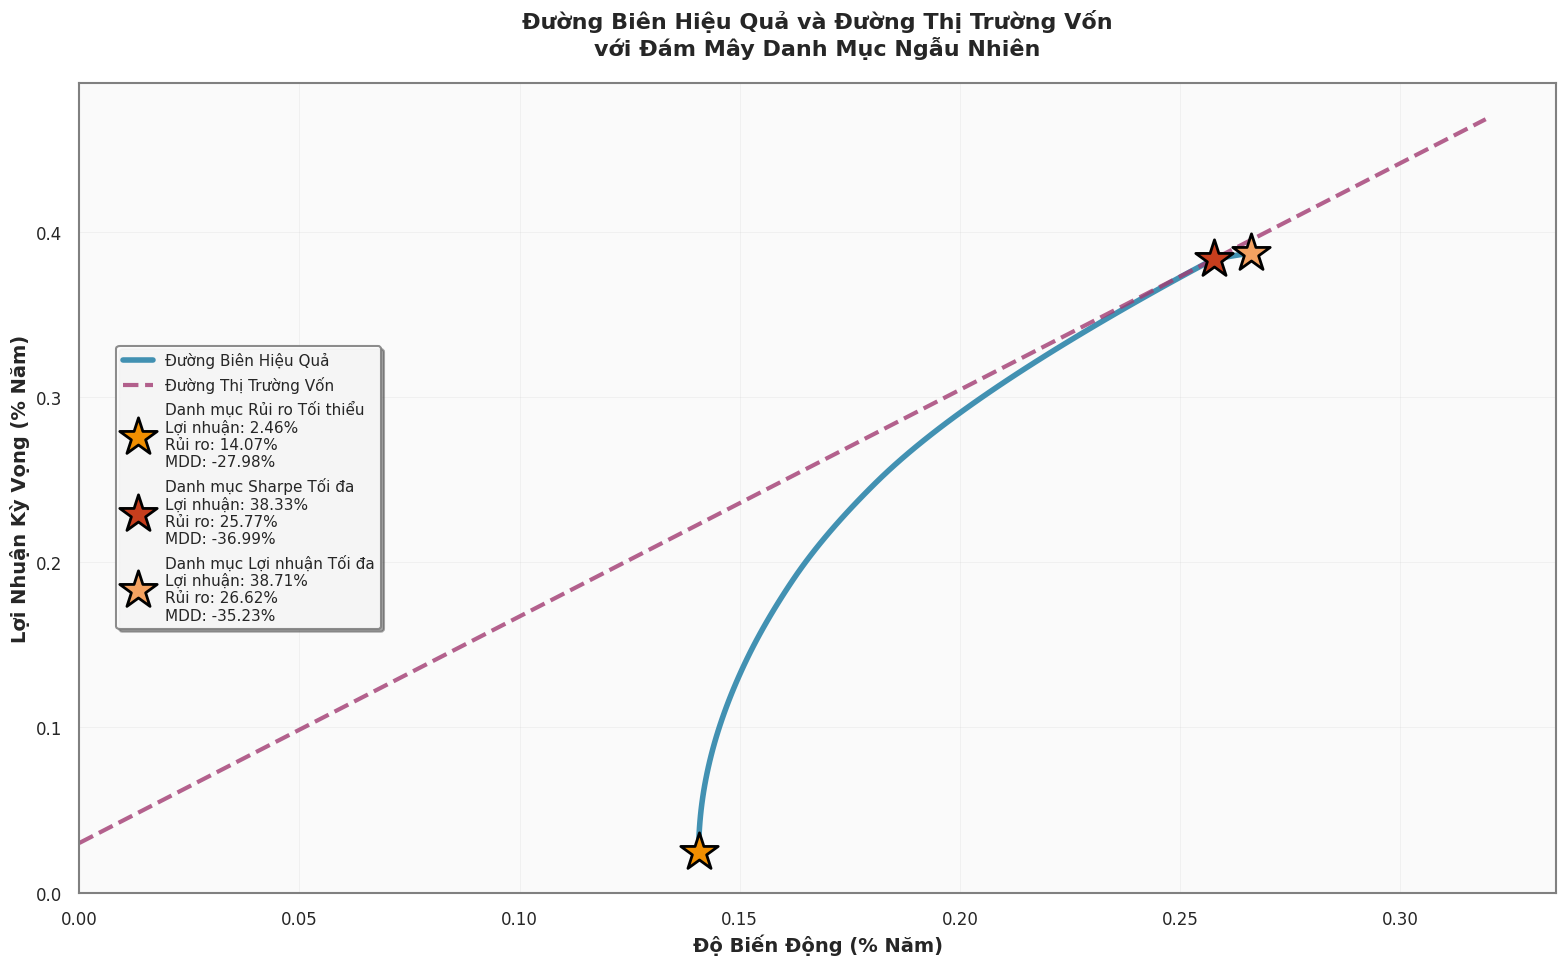

In [23]:

# Thiết lập style cho seaborn
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(16, 10))

# Thiết lập màu sắc
colors = {
    'efficient_frontier': '#2E86AB',
    'capital_market_line': '#A23B72',
    'min_volatility': '#F18F01',
    'max_sharpe': '#C73E1D',
    'max_return': '#F4A261'
}

# Vẽ Efficient Frontier
ax.plot(ef_volatilities, ef_returns, 
        color=colors['efficient_frontier'], 
        linewidth=4, 
        label='Đường Biên Hiệu Quả',
        alpha=0.9)

# Vẽ Capital Market Line
ax.plot(cml_volatilities, cml_returns, 
        color=colors['capital_market_line'], 
        linestyle='--', 
        linewidth=3, 
        label='Đường Thị Trường Vốn',
        alpha=0.8)

# Đánh dấu điểm Min Volatility
ax.scatter(min_volatility, min_return, marker='*', color=colors['min_volatility'], s=800,edgecolors='black', linewidth=2,
           label=f'Danh mục Rủi ro Tối thiểu\nLợi nhuận: {min_return:.2%}\nRủi ro: {min_volatility:.2%}\nMDD: {mdd_min_vol:.2%}', zorder=5)

# Đánh dấu điểm Max Sharpe
ax.scatter(sharpe_volatility, sharpe_return, marker='*', color=colors['max_sharpe'], s=800,edgecolors='black', linewidth=2,
           label=f'Danh mục Sharpe Tối đa\nLợi nhuận: {sharpe_return:.2%}\nRủi ro: {sharpe_volatility:.2%}\nMDD: {mdd_max_sharpe:.2%}', zorder=5)

# Đánh dấu điểm Max Return
ax.scatter(max_volatility, max_return, marker='*', color=colors['max_return'], s=800,edgecolors='black', linewidth=2,
           label=f'Danh mục Lợi nhuận Tối đa\nLợi nhuận: {max_return:.2%}\nRủi ro: {max_volatility:.2%}\nMDD: {mdd_max_return:.2%}', zorder=5)

# Tùy chỉnh biểu đồ
ax.set_xlabel('Độ Biến Động (% Năm)', fontsize=14, fontweight='bold')
ax.set_ylabel('Lợi Nhuận Kỳ Vọng (% Năm)', fontsize=14, fontweight='bold')
ax.set_title('Đường Biên Hiệu Quả và Đường Thị Trường Vốn\nvới Đám Mây Danh Mục Ngẫu Nhiên', 
             fontsize=16, fontweight='bold', pad=20)

# Cải thiện legend
legend = ax.legend(loc='center left', bbox_to_anchor=(0.02, 0.5), fontsize=11, frameon=True, fancybox=True, shadow=True, framealpha=0.9, facecolor='white', edgecolor='gray')

# Cải thiện grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_facecolor('#fafafa')

# Cải thiện tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Thiết lập giới hạn trục để tối ưu hóa hiển thị
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Thêm viền cho biểu đồ
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1.5)

plt.tight_layout()

# Hiển thị thông tin chi tiết
print("KẾT QUẢ PHÂN TÍCH DANH MỤC ĐẦU TƯ")
print(f"Lãi suất phi rủi ro: {risk_free_rate:.2%}")
print(f"Số lượng tài sản: {num_assets}")
print(f"Thời gian phân tích: {len(daily_returns)} ngày")

print(f"\nDanh mục Rủi ro Tối thiểu:")
print(f"  Lợi nhuận: {min_return:.2%}")
print(f"  Độ biến động: {min_volatility:.2%}")
print(f"  Tỷ lệ Sharpe: {(min_return - risk_free_rate)/min_volatility:.3f}")
print(f"  Mức sụt giảm tối đa: {mdd_min_vol:.2%}")

print(f"\nDanh mục Sharpe Tối đa:")
print(f"  Lợi nhuận: {sharpe_return:.2%}")
print(f"  Độ biến động: {sharpe_volatility:.2%}")
print(f"  Tỷ lệ Sharpe: {(sharpe_return - risk_free_rate)/sharpe_volatility:.3f}")
print(f"  Mức sụt giảm tối đa: {mdd_max_sharpe:.2%}")

print(f"\nDanh mục Lợi nhuận Tối đa:")
print(f"  Lợi nhuận: {max_return:.2%}")
print(f"  Độ biến động: {max_volatility:.2%}")
print(f"  Tỷ lệ Sharpe: {(max_return - risk_free_rate)/max_volatility:.3f}")
print(f"  Mức sụt giảm tối đa: {mdd_max_return:.2%}")

plt.show()

PHẦN 5: SỬ DỤNG MONTE CARLO SIMULATION ĐỂ DỰ ĐOÁN GIÁ TRỊ CỦA DANH MỤC ĐẦU TƯ VỚI GIẢ ĐỊNH VỐN BAN ĐẦU LÀ 100 TRIỆU VÀ TRỰC QUAN HÓA

In [24]:
# Gỉa sử tỷ trọng được chọn từ tỷ trọng của danh mục có max Sharpe Ratio
# Tính toán thông số danh mục tối ưu
portfolio_mean_return = np.sum(mean_returns * optimal_weights)*252
portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))*252
portfolio_std = np.sqrt(portfolio_variance)

# Monte Carlo Simulation với Geometric Brownian Motion (GBM)
def monte_carlo_gbm(initial_investment, annual_return, annual_volatility, time_horizon, num_simulations):
    """
    Mô phỏng Monte Carlo sử dụng Geometric Brownian Motion
    
    Parameters:
    - initial_investment: Vốn đầu tư ban đầu
    - annual_return: Tỷ suất sinh lời trung bình hàng năm
    - annual_volatility: Độ biến động hàng năm
    - time_horizon: Số ngày giao dịch
    - num_simulations: Số lần mô phỏng
    """
    
    # Chuyển đổi từ annual sang daily parameters
    dt = 1/252  # Time step (daily)
    mu = annual_return  # Drift 
    sigma = annual_volatility  # Volatility 
    
    # Khởi tạo ma trận kết quả
    results = np.zeros((num_simulations, time_horizon + 1))
    results[:, 0] = initial_investment
    
    # Thiết lập seed cho reproducibility
    np.random.seed(42)
    
    # Mô phỏng GBM cho từng path
    for i in range(num_simulations):
        for t in range(1, time_horizon + 1):
            # Tạo random shock từ phân phối chuẩn
            Z = np.random.normal(0, 1)
            
            # Công thức GBM: S(t) = S(t-1) * exp((μ - σ²/2)*dt + σ*sqrt(dt)*Z)
            results[i, t] = results[i, t-1] * np.exp(
                (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
            )
    
    return results

# Thực hiện mô phỏng Monte Carlo
initial_investment = 10000000  # 10 triệu VND
time_horizon = 3 * 252  # 3 năm = 756 ngày giao dịch
num_simulations = 10000

# Chạy mô phỏng với GBM
simulation_results = monte_carlo_gbm(initial_investment, portfolio_mean_return, portfolio_std, time_horizon, num_simulations)

# Phân tích kết quả
final_values = simulation_results[:, -1]
final_returns = (final_values - initial_investment) / initial_investment * 100

# Tính toán các thống kê rủi ro
def calculate_risk_metrics(final_values, initial_investment):
    """Tính toán các chỉ số rủi ro"""
    
    # Value at Risk (VaR)
    var_95 = np.percentile(final_values, 5)
    var_99 = np.percentile(final_values, 1)
    
    # Conditional Value at Risk (CVaR)
    cvar_95 = np.mean(final_values[final_values <= var_95])
    cvar_99 = np.mean(final_values[final_values <= var_99])
    
    # Maximum Drawdown
    cumulative_returns = simulation_results / initial_investment
    running_max = np.maximum.accumulate(cumulative_returns, axis=1)
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdown, axis=1)
    
    return {
        'var_95': var_95,
        'var_99': var_99,
        'cvar_95': cvar_95,
        'cvar_99': cvar_99,
        'max_drawdown': np.mean(max_drawdown)
    }

# Tính toán metrics
risk_metrics = calculate_risk_metrics(final_values, initial_investment)

# In kết quả chi tiết
print("\nKẾT QUẢ MÔ PHỎNG MONTE CARLO VỚI GBM")
print(f"Vốn đầu tư ban đầu: {initial_investment:,.0f} VND")
print(f"Kỳ vọng sinh lời hàng năm: {portfolio_mean_return:.2%}")
print(f"Độ biến động hàng năm: {portfolio_std:.2%}")
print(f"Thời gian đầu tư: {time_horizon/252:.0f} năm")
print(f"Số lần mô phỏng: {num_simulations:,}")

print(f"\nKết quả sau {time_horizon/252:.0f} năm:")
print(f"Giá trị kỳ vọng: {np.mean(final_values):,.0f} VND")
print(f"Giá trị trung vị: {np.median(final_values):,.0f} VND")
print(f"Tỷ suất sinh lời kỳ vọng: {np.mean(final_returns):.2f}%")
print(f"Độ biến động kết quả: {np.std(final_returns):.2f}%")

print(f"\nPhân tích rủi ro:")
print(f"Xác suất thua lỗ: {np.sum(final_values < initial_investment)/len(final_values)*100:.2f}%")
print(f"Xác suất gấp đôi: {np.sum(final_values > 2*initial_investment)/len(final_values)*100:.2f}%")
print(f"VaR 95%: {risk_metrics['var_95']:,.0f} VND")
print(f"VaR 99%: {risk_metrics['var_99']:,.0f} VND")
print(f"CVaR 95%: {risk_metrics['cvar_95']:,.0f} VND")
print(f"CVaR 99%: {risk_metrics['cvar_99']:,.0f} VND")
print(f"Max Drawdown trung bình: {risk_metrics['max_drawdown']:.2%}")

print(f"\nThua lỗ tiềm năng:")
print(f"Thua lỗ tối đa (VaR 99%): {(initial_investment - risk_metrics['var_99'])/1_000_000:.1f} triệu VND")
print(f"Thua lỗ trung bình (CVaR 95%): {(initial_investment - risk_metrics['cvar_95'])/1_000_000:.1f} triệu VND")




KẾT QUẢ MÔ PHỎNG MONTE CARLO VỚI GBM
Vốn đầu tư ban đầu: 10,000,000 VND
Kỳ vọng sinh lời hàng năm: 38.33%
Độ biến động hàng năm: 25.77%
Thời gian đầu tư: 3 năm
Số lần mô phỏng: 10,000

Kết quả sau 3 năm:
Giá trị kỳ vọng: 31,480,054 VND
Giá trị trung vị: 28,664,474 VND
Tỷ suất sinh lời kỳ vọng: 214.80%
Độ biến động kết quả: 146.20%

Phân tích rủi ro:
Xác suất thua lỗ: 0.85%
Xác suất gấp đôi: 79.00%
VaR 95%: 13,919,190 VND
VaR 99%: 10,269,177 VND
CVaR 95%: 11,749,960 VND
CVaR 99%: 8,939,797 VND
Max Drawdown trung bình: -24.25%

Thua lỗ tiềm năng:
Thua lỗ tối đa (VaR 99%): -0.3 triệu VND
Thua lỗ trung bình (CVaR 95%): -1.7 triệu VND


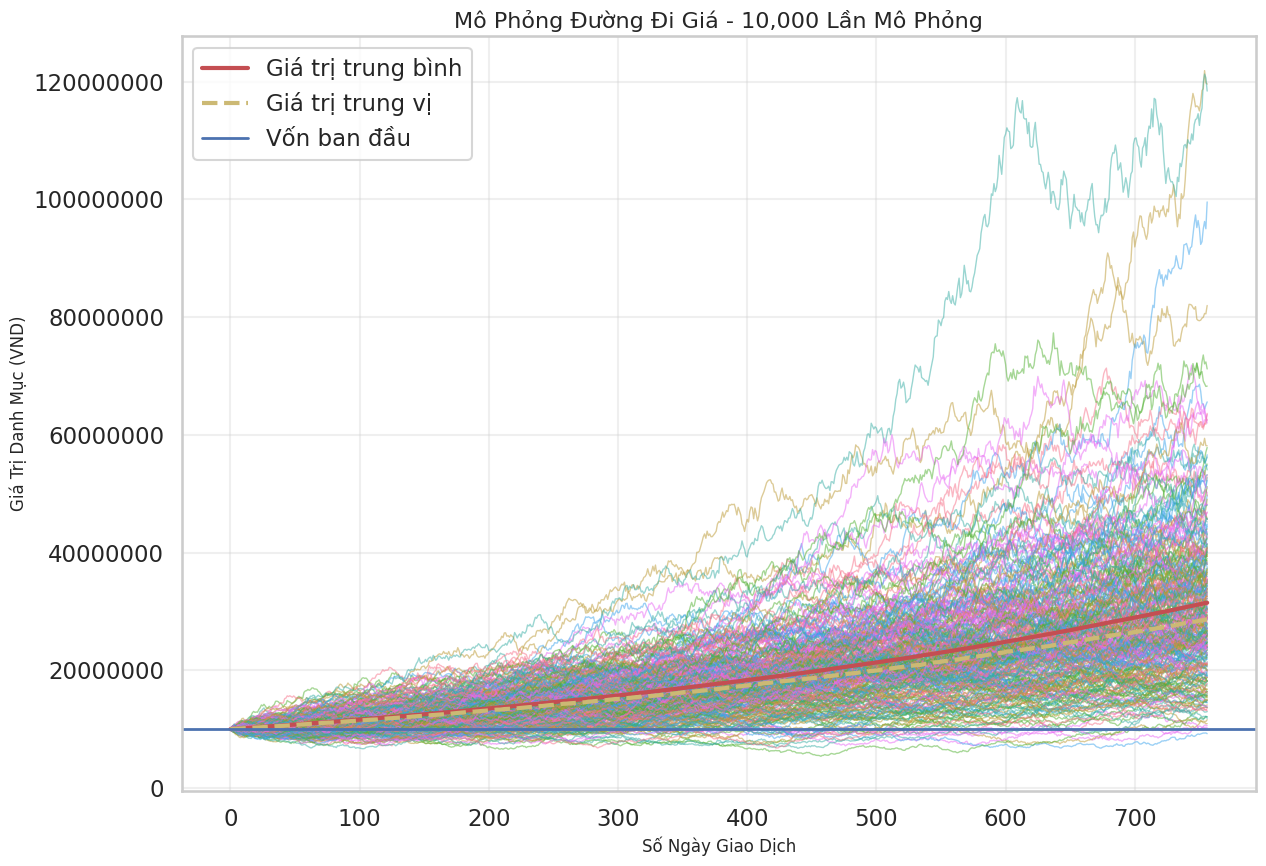

In [25]:
# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)


# Biểu đồ mô phỏng đường đi của giá (300 đường đầu tiên)
plt.figure(figsize=(13, 9))
sample_paths = simulation_results[:300]  

# Vẽ tất cả các đường mô phỏng
for i in range(len(sample_paths)):
    plt.plot(sample_paths[i], lw=1, alpha=0.5)

# Tính toán và vẽ đường trung bình
mean_path = np.mean(simulation_results, axis=0)
plt.plot(mean_path, 'r-', lw=3, label='Giá trị trung bình')

# Tính toán và vẽ đường trung vị
median_path = np.median(simulation_results, axis=0)
plt.plot(median_path, 'y--', lw=3, label='Giá trị trung vị')

# Vẽ đường giá trị ban đầu
plt.axhline(y=initial_investment, color='b', linestyle='-', lw=2, label='Vốn ban đầu')

# Thiết lập thông số biểu đồ
plt.title(f'Mô Phỏng Đường Đi Giá - {num_simulations:,} Lần Mô Phỏng', fontsize=16)
plt.xlabel('Số Ngày Giao Dịch', fontsize=12)
plt.ylabel('Giá Trị Danh Mục (VND)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(axis='y', style='plain')

# Hiển thị giá trị cuối kỳ trung bình và trung vị
final_mean = np.mean(final_values)
final_median = np.median(final_values)
plt.tight_layout()
plt.show()

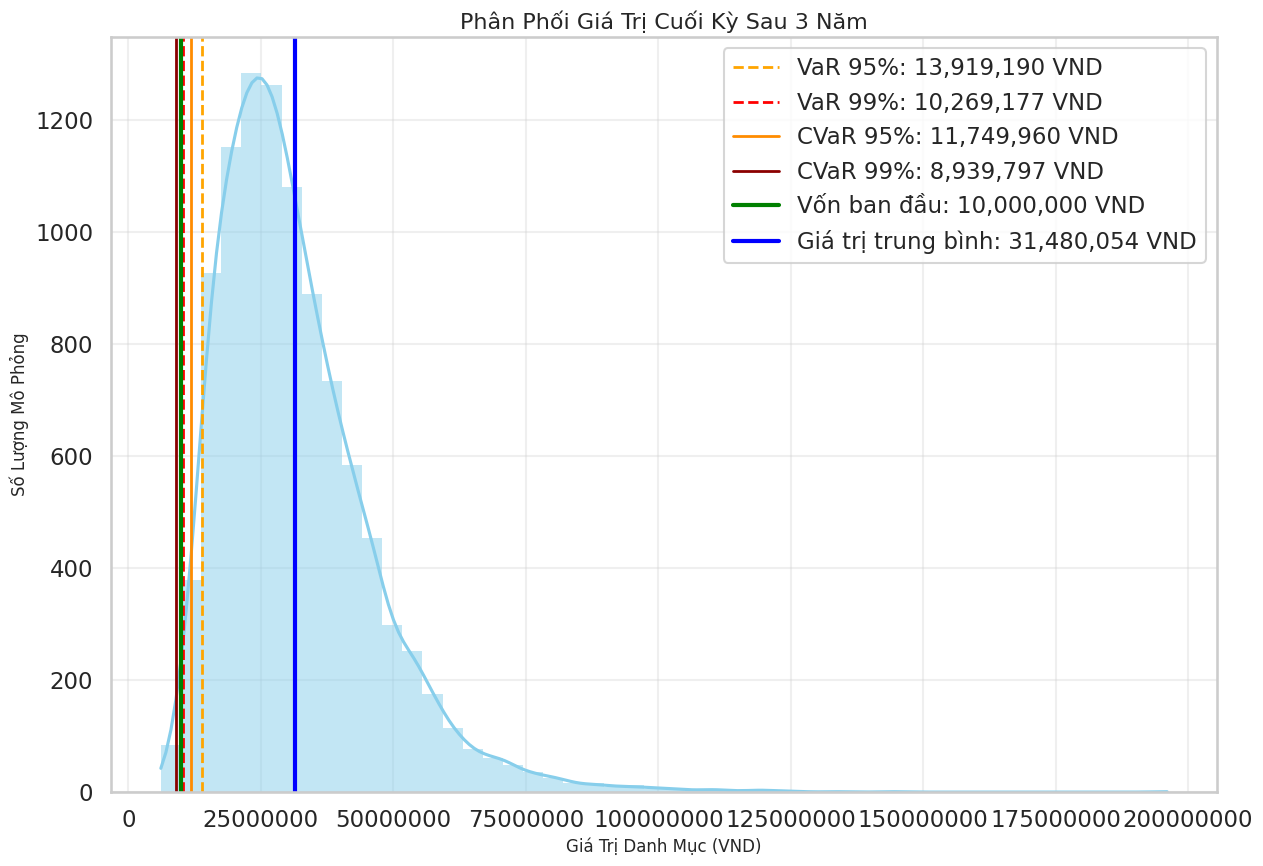

In [26]:
# Biểu đồ phân phối giá trị cuối kỳ (Histogram)
plt.figure(figsize=(13, 9))

# Vẽ histogram
sns.histplot(final_values, bins=50, kde=True, color='skyblue', edgecolor='none')

# Thêm các đường VaR và CVaR
plt.axvline(x=risk_metrics['var_95'], color='orange', linestyle='--', lw=2, 
            label=f'VaR 95%: {risk_metrics["var_95"]:,.0f} VND')
plt.axvline(x=risk_metrics['var_99'], color='red', linestyle='--', lw=2, 
            label=f'VaR 99%: {risk_metrics["var_99"]:,.0f} VND')
plt.axvline(x=risk_metrics['cvar_95'], color='darkorange', linestyle='-', lw=2, 
            label=f'CVaR 95%: {risk_metrics["cvar_95"]:,.0f} VND')
plt.axvline(x=risk_metrics['cvar_99'], color='darkred', linestyle='-', lw=2, 
            label=f'CVaR 99%: {risk_metrics["cvar_99"]:,.0f} VND')

# Thêm đường giá trị ban đầu và giá trị trung bình
plt.axvline(x=initial_investment, color='green', linestyle='-', lw=3, 
            label=f'Vốn ban đầu: {initial_investment:,.0f} VND')
plt.axvline(x=np.mean(final_values), color='blue', linestyle='-', lw=3, 
            label=f'Giá trị trung bình: {np.mean(final_values):,.0f} VND')

# Thiết lập thông số biểu đồ
plt.title('Phân Phối Giá Trị Cuối Kỳ Sau 3 Năm', fontsize=16)
plt.xlabel('Giá Trị Danh Mục (VND)', fontsize=12)
plt.ylabel('Số Lượng Mô Phỏng', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(axis='x', style='plain')
plt.tight_layout()
plt.show()


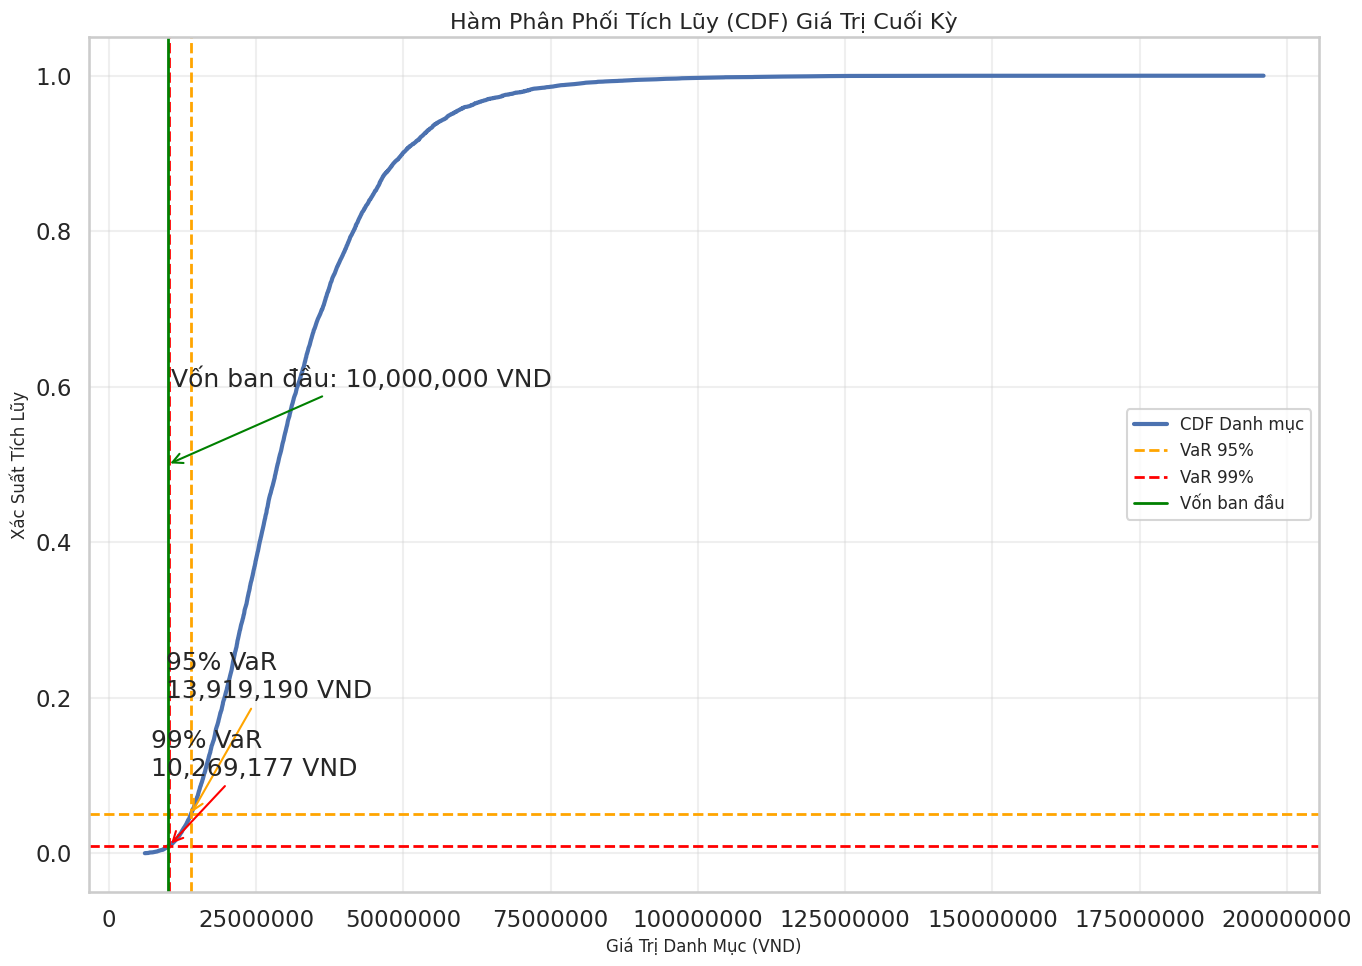

In [27]:
# Tạo kích thước biểu đồ
plt.figure(figsize=(14, 10))

# Tính toán và vẽ CDF
sorted_vals = np.sort(final_values)
cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
plt.plot(sorted_vals, cdf, 'b-', lw=3, label='CDF Danh mục')

# Thêm các đường VaR
var_95_val = risk_metrics['var_95']
var_99_val = risk_metrics['var_99']

plt.axvline(x=var_95_val, color='orange', linestyle='--', lw=2, label='VaR 95%')
plt.axhline(y=0.05, color='orange', linestyle='--', lw=2)

plt.axvline(x=var_99_val, color='red', linestyle='--', lw=2, label='VaR 99%')
plt.axhline(y=0.01, color='red', linestyle='--', lw=2)

# Đường vốn ban đầu
plt.axvline(x=initial_investment, color='green', linestyle='-', lw=2, label='Vốn ban đầu')

# Chú thích cho VaR
plt.annotate(f'95% VaR\n{var_95_val:,.0f} VND', 
             xy=(var_95_val, 0.05), 
             xytext=(var_95_val*0.7, 0.2),
             arrowprops=dict(arrowstyle="->", color='orange'))
plt.annotate(f'99% VaR\n{var_99_val:,.0f} VND', 
             xy=(var_99_val, 0.01), 
             xytext=(var_99_val*0.7, 0.1),
             arrowprops=dict(arrowstyle="->", color='red'))

# Chú thích vốn ban đầu
plt.annotate(f'Vốn ban đầu: {initial_investment:,.0f} VND', 
             xy=(initial_investment, 0.5), 
             xytext=(initial_investment*1.05, 0.6),
             arrowprops=dict(arrowstyle="->", color='green'))

# Thiết lập thông số biểu đồ
plt.title('Hàm Phân Phối Tích Lũy (CDF) Giá Trị Cuối Kỳ', fontsize=16)
plt.xlabel('Giá Trị Danh Mục (VND)', fontsize=12)
plt.ylabel('Xác Suất Tích Lũy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ticklabel_format(axis='x', style='plain')

# Thêm legend để giải thích màu sắc
plt.legend(loc='best', fontsize=12)

plt.tight_layout()
plt.show()


PHẦN 6: STRESS TESTING TRONG CÁC ĐIỀU KIỆN NỀ KINH TẾ CÓ BIẾN ĐỘNG MẠNH, LẤY CÁC BỐI CẢNH LỊCH SỬ TRÊN THẾ GIỚI 

KẾT QUẢ STRESS TESTING DANH MỤC ĐẦU TƯ
THÔNG TIN DANH MỤC HIỆN TẠI:
Lợi nhuận kỳ vọng: 38.33%
Độ biến động: 25.77%
Sharpe Ratio: 1.371

KỊCH BẢN STRESS TEST LỊCH SỬ:
Khủng hoảng tài chính 2008:
Lợi nhuận: 38.33% → 13.42% (-24.92%)
Volatility: 25.77% → 97.39% (71.62%)
Sharpe: 1.371 → 0.107 (-1.264)

COVID-19 Pandemic 2020:
Lợi nhuận: 38.33% → 25.68% (-12.65%)
Volatility: 25.77% → 84.21% (58.44%)
Sharpe: 1.371 → 0.269 (-1.102)

Dot-com Bubble 2000:
Lợi nhuận: 38.33% → 23.00% (-15.33%)
Volatility: 25.77% → 55.16% (29.39%)
Sharpe: 1.371 → 0.363 (-1.009)

Khủng hoảng nợ châu Âu 2011:
Lợi nhuận: 38.33% → 32.58% (-5.75%)
Volatility: 25.77% → 42.91% (17.14%)
Sharpe: 1.371 → 0.689 (-0.682)

Bong bóng bất động sản Việt Nam 2013:
Lợi nhuận: 38.33% → 28.75% (-9.58%)
Volatility: 25.77% → 59.56% (33.79%)
Sharpe: 1.371 → 0.432 (-0.939)

Chiến tranh thương mại 2018:
Lợi nhuận: 38.33% → 30.67% (-7.67%)
Volatility: 25.77% → 48.27% (22.50%)
Sharpe: 1.371 → 0.573 (-0.798)

PHÂN TÍCH VALUE AT RISK:
VaR_95%

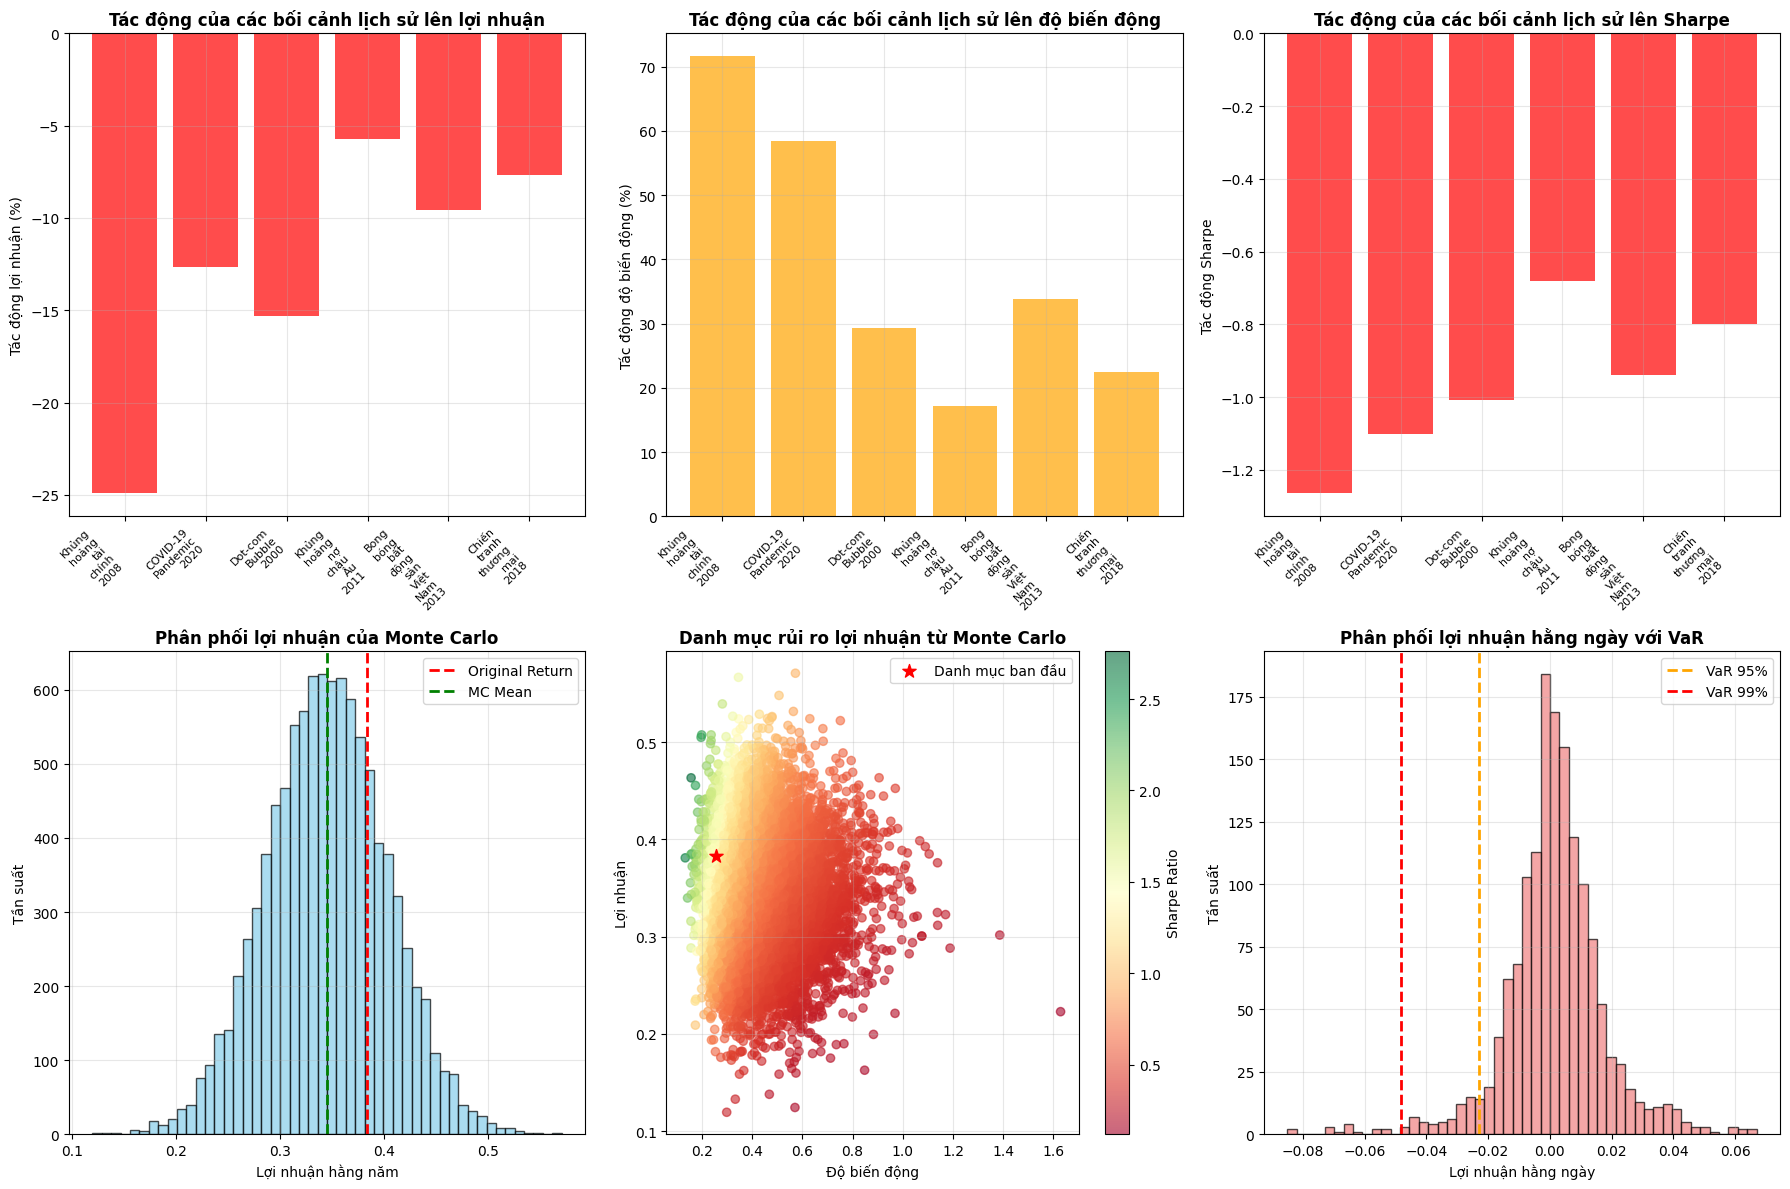

In [28]:
# Định nghĩa hàm và truyền vào cũng như tính toán các tham số
class PortfolioStressTesting:
    def __init__(self, optimal_weights, mean_returns, cov_matrix, daily_returns, risk_free_rate=0.03):
        self.weights = np.array(optimal_weights)
        self.mean_returns = np.array(mean_returns)
        self.cov_matrix = np.array(cov_matrix)
        self.daily_returns = daily_returns
        self.risk_free_rate = risk_free_rate
        self.periods_per_year = 252
        
        # Tính toán các chỉ số danh mục hiện tại
        self.portfolio_return = np.sum(self.mean_returns * self.weights) * 252
        self.portfolio_vol = np.sqrt(np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))) * np.sqrt(252)
        self.sharpe_ratio = (self.portfolio_return - risk_free_rate) / self.portfolio_vol
        
        # Tính daily portfolio returns
        self.portfolio_daily_returns = (daily_returns * self.weights).sum(axis=1)
        
    def historical_stress_scenarios(self):
        """Các kịch bản stress test dựa trên sự kiện lịch sử"""
        scenarios = {
            'Khủng hoảng tài chính 2008': {
                'market_shock': -0.65,  # S&P 500 giảm 45%
                'volatility_multiplier': 3.5,
                'correlation_increase': 0.4
            },
            'COVID-19 Pandemic 2020': {
                'market_shock': -0.33,  # Crash tháng 3/2020
                'volatility_multiplier': 3.0,
                'correlation_increase': 0.45
            },
            'Dot-com Bubble 2000': {
                'market_shock': -0.40,
                'volatility_multiplier': 2.0,
                'correlation_increase': 0.35
            },
            'Khủng hoảng nợ châu Âu 2011': {
                'market_shock': -0.15,
                'volatility_multiplier': 1.6,
                'correlation_increase': 0.2
            },
            'Bong bóng bất động sản Việt Nam 2013': {
                'market_shock': -0.25,
                'volatility_multiplier': 2.2,
                'correlation_increase': 0.25
            },
            'Chiến tranh thương mại 2018': {
                'market_shock': -0.20,
                'volatility_multiplier': 1.8,
                'correlation_increase': 0.2
            }
        }
        return scenarios
    
    def apply_stress_scenario(self, scenario_name, scenario_params):
        """Áp dụng kịch bản stress test cụ thể"""
        market_shock = scenario_params['market_shock']
        vol_multiplier = scenario_params['volatility_multiplier']
        corr_increase = scenario_params['correlation_increase']
        
        # Shock return: Giảm expected return
        stressed_returns = self.mean_returns * (1 + market_shock)
        
        # Tăng volatility
        stressed_cov = self.cov_matrix * (vol_multiplier ** 2)
        
        # Tăng correlation
        # Chuyển covariance thành correlation
        std_devs = np.sqrt(np.diag(self.cov_matrix))
        corr_matrix = self.cov_matrix / np.outer(std_devs, std_devs)
        
        # Tăng correlation (chặn bởi 1)
        stressed_corr = np.minimum(corr_matrix + corr_increase, 0.95)
        np.fill_diagonal(stressed_corr, 1.0)
        
        # Chuyển về covariance với volatility đã tăng
        stressed_std = std_devs * vol_multiplier
        stressed_cov = stressed_corr * np.outer(stressed_std, stressed_std)
        
        # Tính performance của danh mục trong kịch bản stress
        stressed_portfolio_return = np.sum(stressed_returns * self.weights) * 252
        stressed_portfolio_vol = np.sqrt(np.dot(self.weights.T, np.dot(stressed_cov, self.weights))) * np.sqrt(252)
        stressed_sharpe = (stressed_portfolio_return - self.risk_free_rate) / stressed_portfolio_vol
        
        return {
            'scenario': scenario_name,
            'original_return': self.portfolio_return,
            'stressed_return': stressed_portfolio_return,
            'original_volatility': self.portfolio_vol,
            'stressed_volatility': stressed_portfolio_vol,
            'original_sharpe': self.sharpe_ratio,
            'stressed_sharpe': stressed_sharpe,
            'return_impact': stressed_portfolio_return - self.portfolio_return,
            'volatility_impact': stressed_portfolio_vol - self.portfolio_vol,
            'sharpe_impact': stressed_sharpe - self.sharpe_ratio
        }
    def monte_carlo_stress_test(self, num_simulations=10000):
        """Monte Carlo stress testing"""
        np.random.seed(42)
        
        # Tạo random shocks
        market_shocks = np.random.normal(-0.10, 0.15, num_simulations)  # Mean -10%, std 15%
        vol_multipliers = np.random.lognormal(0.5, 0.3, num_simulations)  # Lognormal distribution
        
        stressed_returns = []
        stressed_volatilities = []
        stressed_sharpes = []
        
        for i in range(num_simulations):
            # Áp dụng random shock
            shock_returns = self.mean_returns * (1 + market_shocks[i])
            shock_cov = self.cov_matrix * (vol_multipliers[i] ** 2)
            
            # Tính các đo lường stressed
            port_return = np.sum(shock_returns * self.weights) * 252
            port_vol = np.sqrt(np.dot(self.weights.T, np.dot(shock_cov, self.weights))) * np.sqrt(252)
            sharpe = (port_return - self.risk_free_rate) / port_vol
            
            stressed_returns.append(port_return)
            stressed_volatilities.append(port_vol)
            stressed_sharpes.append(sharpe)
        
        return {
            'returns': np.array(stressed_returns),
            'volatilities': np.array(stressed_volatilities),
            'sharpes': np.array(stressed_sharpes)
        }
    
    def value_at_risk(self, confidence_levels=[0.95, 0.99]):
        """Tính Value at Risk (VaR) và Expected Shortfall (ES)"""
        # Chuyển portfolio returns thành numpy array 
        if isinstance(self.portfolio_daily_returns, pd.Series):
            portfolio_returns = self.portfolio_daily_returns.values
        else:
            portfolio_returns = self.portfolio_daily_returns
        
        results = {}
        for confidence in confidence_levels:
            # VaR: Percentile loss
            var = np.percentile(portfolio_returns, (1 - confidence) * 100)
            
            # Expected Shortfall: Trung bình lỗ khi vượt qua VaR
            es = portfolio_returns[portfolio_returns <= var].mean()
            
            results[f'VaR_{int(confidence*100)}%'] = var
            results[f'ES_{int(confidence*100)}%'] = es
        
        return results
    
    def tail_risk_analysis(self):
        """Phân tích tail risk"""
        # Chuyển portfolio returns thành numpy array 
        if isinstance(self.portfolio_daily_returns, pd.Series):
            portfolio_returns = self.portfolio_daily_returns.values
        else:
            portfolio_returns = self.portfolio_daily_returns
        
        # Tính các chỉ số tail risk
        skewness = stats.skew(portfolio_returns)
        kurtosis = stats.kurtosis(portfolio_returns)
        
        # Maximum drawdown
        if isinstance(self.portfolio_daily_returns, pd.Series):
            cumulative_returns = (1 + self.portfolio_daily_returns).cumprod()
            running_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = drawdown.min()
        else:
            cumulative_returns = np.cumprod(1 + portfolio_returns)
            running_max = np.maximum.accumulate(cumulative_returns)
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = np.min(drawdown)
        
        return {
            'skewness': skewness,
            'kurtosis': kurtosis,
            'max_drawdown': max_drawdown,
            'worst_day': np.min(portfolio_returns),
            'best_day': np.max(portfolio_returns)
        }
    
    def run_comprehensive_stress_test(self):
        """Chạy toàn bộ stress test"""
        print("KẾT QUẢ STRESS TESTING DANH MỤC ĐẦU TƯ")
        
        # Thông tin danh mục hiện tại
        print("THÔNG TIN DANH MỤC HIỆN TẠI:")
        print(f"Lợi nhuận kỳ vọng: {self.portfolio_return:.2%}")
        print(f"Độ biến động: {self.portfolio_vol:.2%}")
        print(f"Sharpe Ratio: {self.sharpe_ratio:.3f}")
        print()
        
        # Stress test lịch sử với những kịch bản 
        print("KỊCH BẢN STRESS TEST LỊCH SỬ:")
        scenarios = self.historical_stress_scenarios()
        historical_results = []
        
        for scenario_name, params in scenarios.items():
            result = self.apply_stress_scenario(scenario_name, params)
            historical_results.append(result)
            
            print(f"{scenario_name}:")
            print(f"Lợi nhuận: {result['original_return']:.2%} → {result['stressed_return']:.2%} ({result['return_impact']:.2%})")
            print(f"Volatility: {result['original_volatility']:.2%} → {result['stressed_volatility']:.2%} ({result['volatility_impact']:.2%})")
            print(f"Sharpe: {result['original_sharpe']:.3f} → {result['stressed_sharpe']:.3f} ({result['sharpe_impact']:.3f})")
            print()
        
        # Phân tích VaR
        print("PHÂN TÍCH VALUE AT RISK:")
        var_results = self.value_at_risk()
        for metric, value in var_results.items():
            print(f"{metric}: {value:.2%}")
        print()
        
        # Phân tích Tail Risk
        print("PHÂN TÍCH TAIL RISK:")
        tail_results = self.tail_risk_analysis()
        print(f"Skewness: {tail_results['skewness']:.3f}")
        print(f"Kurtosis: {tail_results['kurtosis']:.3f}")
        print(f"Max Drawdown: {tail_results['max_drawdown']:.2%}")
        print(f"Worst Day: {tail_results['worst_day']:.2%}")
        print(f"Best Day: {tail_results['best_day']:.2%}")
        print()
        
        # Kết quả của Monte Carlo
        print("MONTE CARLO STRESS TEST:")
        mc_results = self.monte_carlo_stress_test()
        print(f"Lợi nhuận trung bình: {mc_results['returns'].mean():.2%}")
        print(f"Lợi nhuận tồi tệ nhất (5%): {np.percentile(mc_results['returns'], 5):.2%}")
        print(f"Volatility trung bình: {mc_results['volatilities'].mean():.2%}")
        print(f"Sharpe trung bình: {mc_results['sharpes'].mean():.3f}")
        
        return historical_results, mc_results, var_results, tail_results
    
    def visualize_stress_test(self, historical_results, mc_results):
        """Trực quan hóa kết quả stress test"""
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Tác động của các bối cảnh lịch sử
        scenarios = [r['scenario'] for r in historical_results]
        return_impacts = [r['return_impact'] for r in historical_results]
        vol_impacts = [r['volatility_impact'] for r in historical_results]
        sharpe_impacts = [r['sharpe_impact'] for r in historical_results]
        
        ax1 = axes[0, 0]
        x_pos = np.arange(len(scenarios))
        colors = ['red' if x < 0 else 'green' for x in return_impacts]
        bars = ax1.bar(x_pos, [x*100 for x in return_impacts], color=colors, alpha=0.7)
        ax1.set_title('Tác động của các bối cảnh lịch sử lên lợi nhuận', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Tác động lợi nhuận (%)')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([s.replace(' ', '\n') for s in scenarios], rotation=45, ha='right', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Tác động lên rủi ro 
        ax2 = axes[0, 1]
        ax2.bar(x_pos, [x*100 for x in vol_impacts], color='orange', alpha=0.7)
        ax2.set_title('Tác động của các bối cảnh lịch sử lên độ biến động', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Tác động độ biến động (%)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([s.replace(' ', '\n') for s in scenarios], rotation=45, ha='right', fontsize=8)
        ax2.grid(True, alpha=0.3)
        
        # Tác động lên Sharpe ratio
        ax3 = axes[0, 2]
        colors = ['red' if x < 0 else 'green' for x in sharpe_impacts]
        bars = ax3.bar(x_pos, sharpe_impacts, color=colors, alpha=0.7)
        ax3.set_title('Tác động của các bối cảnh lịch sử lên Sharpe', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Tác động Sharpe')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels([s.replace(' ', '\n') for s in scenarios], rotation=45, ha='right', fontsize=8)
        ax3.grid(True, alpha=0.3)
        
        # Phân phối lợi nhuận từ Monte Carlo
        ax4 = axes[1, 0]
        ax4.hist(mc_results['returns'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        ax4.axvline(self.portfolio_return, color='red', linestyle='--', linewidth=2, label='Original Return')
        ax4.axvline(mc_results['returns'].mean(), color='green', linestyle='--', linewidth=2, label='MC Mean')
        ax4.set_title('Phân phối lợi nhuận của Monte Carlo', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Lợi nhuận hằng năm')
        ax4.set_ylabel('Tần suất')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Dùng scatter plot để thể hiện Monte Carlo
        ax5 = axes[1, 1]
        scatter = ax5.scatter(mc_results['volatilities'], mc_results['returns'], 
                            c=mc_results['sharpes'], cmap='RdYlGn', alpha=0.6)
        ax5.scatter(self.portfolio_vol, self.portfolio_return, color='red', s=100, 
                   marker='*', label='Danh mục ban đầu')
        ax5.set_title('Danh mục rủi ro lợi nhuận từ Monte Carlo', fontsize=12, fontweight='bold')
        ax5.set_xlabel('Độ biến động')
        ax5.set_ylabel('Lợi nhuận')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax5, label='Sharpe Ratio')
        
        # Phân phối lợi nhuận hằng ngày của danh mục
        ax6 = axes[1, 2]
        if isinstance(self.portfolio_daily_returns, pd.Series):
            returns_data = self.portfolio_daily_returns.values
        else:
            returns_data = self.portfolio_daily_returns
            
        ax6.hist(returns_data, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        
        # Têm đường VaR
        var_95 = np.percentile(returns_data, 5)
        var_99 = np.percentile(returns_data, 1)
        ax6.axvline(var_95, color='orange', linestyle='--', linewidth=2, label='VaR 95%')
        ax6.axvline(var_99, color='red', linestyle='--', linewidth=2, label='VaR 99%')
        
        ax6.set_title('Phân phối lợi nhuận hằng ngày với VaR', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Lợi nhuận hằng ngày')
        ax6.set_ylabel('Tần suất')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


stress_tester = PortfolioStressTesting(optimal_weights, mean_returns, cov_matrix, daily_returns)
historical_results, mc_results, var_results, tail_results = stress_tester.run_comprehensive_stress_test()
stress_tester.visualize_stress_test(historical_results, mc_results)

PHẦN 7: BACKTESTING VỚI DỮ LIỆU QUÁ KHỨ TỪ 2019 ĐẾN 2025 ĐỒNG THỜI SO SÁNH VỚI DANH MỤC CÓ TỶ TRỌNG ĐỀU VÀ SO SÁNH VỚI CHỈ SỐ VN30

In [29]:
# Đọc dữ liệu
dataframes = pd.read_csv("close_prices_final.csv", parse_dates=['Date'])
dataframes.set_index('Date', inplace=True)

# Đọc dữ liệu VN30
vn30_data = pd.read_csv("close_prices.csv", parse_dates=['Date'])
vn30_data.set_index('Date', inplace=True)

for i, weight in enumerate(optimal_weights):
    print(f"Cổ phiếu {dataframes.columns[i]}: {weight:.4f}")

# Hàm backtesting
def backtest_portfolio(price_data, weights, rebalance_freq='M'):
    """
    Backtest danh mục đầu tư với tái cân bằng định kỳ
    
    Parameters:
    - price_data: DataFrame chứa giá cổ phiếu
    - weights: array trọng số ban đầu
    - rebalance_freq: tần suất tái cân bằng ('M' cho tháng, 'Q' cho quý)
    """
    
    # Tính lợi nhuận hàng ngày
    returns = np.log(price_data/price_data.shift(1)).dropna()
    
    # Tạo DataFrame để lưu kết quả
    portfolio_value = pd.DataFrame(index=returns.index)
    portfolio_value['Portfolio_Value'] = 0.0
    
    # Giá trị ban đầu
    initial_value = 100000
    current_value = initial_value
    current_weights = weights.copy()
    
    # Lấy ngày tái cân bằng
    rebalance_dates = pd.date_range(start=returns.index[0], end=returns.index[-1], freq='MS')
    rebalance_dates = [date for date in rebalance_dates if date in returns.index]
    
    rebalance_idx = 0
    next_rebalance = rebalance_dates[rebalance_idx] if rebalance_idx < len(rebalance_dates) else None
    
    for date in returns.index:
        # Kiểm tra xem có phải ngày tái cân bằng không
        if next_rebalance is not None and date >= next_rebalance:
            # Tính toán lại trọng số tối ưu dựa trên dữ liệu 252 ngày trước
            lookback_period = 252
            start_idx = max(0, returns.index.get_loc(date) - lookback_period)
            historical_returns = returns.iloc[start_idx:returns.index.get_loc(date)]
            
            if len(historical_returns) >= 60:  # Đảm bảo có đủ dữ liệu
                try:
                    hist_mean = historical_returns.mean()
                    hist_cov = historical_returns.cov()
                    
                    # Tối ưu hóa lại trọng số
                    optimal_result = max_sharpe_ratio(hist_mean, hist_cov, risk_free_rate/252)
                    if optimal_result.success:
                        current_weights = optimal_result.x
                    
                except:
                    # Nếu tối ưu hóa thất bại, giữ nguyên trọng số
                    pass
            
            # Chuyển đến ngày tái cân bằng tiếp theo
            rebalance_idx += 1
            next_rebalance = rebalance_dates[rebalance_idx] if rebalance_idx < len(rebalance_dates) else None
        
        # Tính lợi nhuận danh mục trong ngày
        daily_return = np.sum(returns.loc[date] * current_weights)
        current_value *= (1 + daily_return)
        
        portfolio_value.loc[date, 'Portfolio_Value'] = current_value
    
    return portfolio_value

Cổ phiếu ACB_Close: 0.0000
Cổ phiếu BCM_Close: 0.0000
Cổ phiếu BID_Close: 0.0000
Cổ phiếu BVH_Close: 0.0000
Cổ phiếu CTG_Close: 0.0000
Cổ phiếu FPT_Close: 0.8458
Cổ phiếu GAS_Close: 0.0000
Cổ phiếu GVR_Close: 0.0000
Cổ phiếu HDB_Close: 0.0000
Cổ phiếu HPG_Close: 0.0000
Cổ phiếu LPB_Close: 0.1470
Cổ phiếu MSN_Close: 0.0000
Cổ phiếu MWG_Close: 0.0000
Cổ phiếu PLX_Close: 0.0000
Cổ phiếu SAB_Close: 0.0000
Cổ phiếu SHB_Close: 0.0000
Cổ phiếu SSB_Close: 0.0000
Cổ phiếu SSI_Close: 0.0000
Cổ phiếu TPB_Close: 0.0000
Cổ phiếu VCB_Close: 0.0000
Cổ phiếu VHM_Close: 0.0000
Cổ phiếu VIB_Close: 0.0072
Cổ phiếu VIC_Close: 0.0000
Cổ phiếu VJC_Close: 0.0000
Cổ phiếu VNM_Close: 0.0000
Cổ phiếu VPB_Close: 0.0000
Cổ phiếu VRE_Close: 0.0000


In [30]:
# Backtest danh mục tối ưu Sharpe
optimal_portfolio = backtest_portfolio(dataframes, optimal_weights)

# Backtest danh mục chia đều
equal_weights = np.array([1/num_assets] * num_assets)
equal_portfolio = backtest_portfolio(dataframes, equal_weights)

# Chuẩn bị dữ liệu VN30
vn30_portfolio = pd.DataFrame(index=dataframes.index)
vn30_portfolio['Portfolio_Value'] = 0.0

# Giả định VN30 bắt đầu với giá trị 100,000
initial_vn30_value = 100000
vn30_returns = np.log(vn30_data/vn30_data.shift(1)).dropna()

# Tính giá trị VN30 theo thời gian
current_vn30_value = initial_vn30_value
for date in vn30_returns.index:
    if date in vn30_portfolio.index:
        if date in vn30_returns.index:
            daily_return = vn30_returns.loc[date].iloc[0]  # Lấy giá trị đầu tiên nếu có nhiều cột
            current_vn30_value *= (1 + daily_return)
            vn30_portfolio.loc[date, 'Portfolio_Value'] = current_vn30_value

# Loại bỏ các giá trị 0
vn30_portfolio = vn30_portfolio[vn30_portfolio['Portfolio_Value'] > 0]

In [31]:
# Tạo DataFrame tổng hợp
results = pd.DataFrame(index=dataframes.index)
results['Optimal_Sharpe'] = optimal_portfolio['Portfolio_Value']
results['Equal_Weight'] = equal_portfolio['Portfolio_Value']

# Align VN30 data với kết quả
for date in results.index:
    if date in vn30_portfolio.index:
        results.loc[date, 'VN30'] = vn30_portfolio.loc[date, 'Portfolio_Value']

# Loại bỏ các hàng có giá trị NaN
results = results.dropna()

# Tính toán các chỉ số hiệu suất
def calculate_performance_metrics(portfolio_values):
    """Tính toán các chỉ số hiệu suất"""
    returns = np.log(portfolio_values/portfolio_values.shift(1)).dropna()
    
    # Tổng lợi nhuận
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Lợi nhuận hàng năm
    years = len(portfolio_values) / 252
    annual_return = (1 + total_return) ** (1/years) - 1
    
    # Độ biến động hàng năm
    annual_volatility = returns.std() * np.sqrt(252)
    
    # Sharpe ratio
    sharpe = (annual_return - risk_free_rate) / annual_volatility
    
    # Maximum drawdown
    rolling_max = portfolio_values.expanding().max()
    drawdown = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown
    }
# Tính toán hiệu suất cho từng danh mục
print("KẾT QUẢ BACKTEST")
metrics = {}
for column in results.columns:
    if len(results[column].dropna()) > 0:
        metrics[column] = calculate_performance_metrics(results[column].dropna())
        
# In kết quả
for portfolio_name, perf in metrics.items():
    print(f"{portfolio_name}:")
    print(f"Tổng lợi nhuận: {perf['Total Return']:.2%}")
    print(f"Lợi nhuận hàng năm: {perf['Annual Return']:.2%}")
    print(f"Độ biến động hàng năm: {perf['Annual Volatility']:.2%}")
    print(f"Sharpe Ratio: {perf['Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: {perf['Max Drawdown']:.2%}")

KẾT QUẢ BACKTEST
Optimal_Sharpe:
Tổng lợi nhuận: 160.31%
Lợi nhuận hàng năm: 17.45%
Độ biến động hàng năm: 26.54%
Sharpe Ratio: 0.54
Max Drawdown: -45.10%
Equal_Weight:
Tổng lợi nhuận: 137.52%
Lợi nhuận hàng năm: 15.65%
Độ biến động hàng năm: 26.34%
Sharpe Ratio: 0.48
Max Drawdown: -45.10%
VN30:
Tổng lợi nhuận: 172.89%
Lợi nhuận hàng năm: 18.38%
Độ biến động hàng năm: 28.19%
Sharpe Ratio: 0.55
Max Drawdown: -45.55%


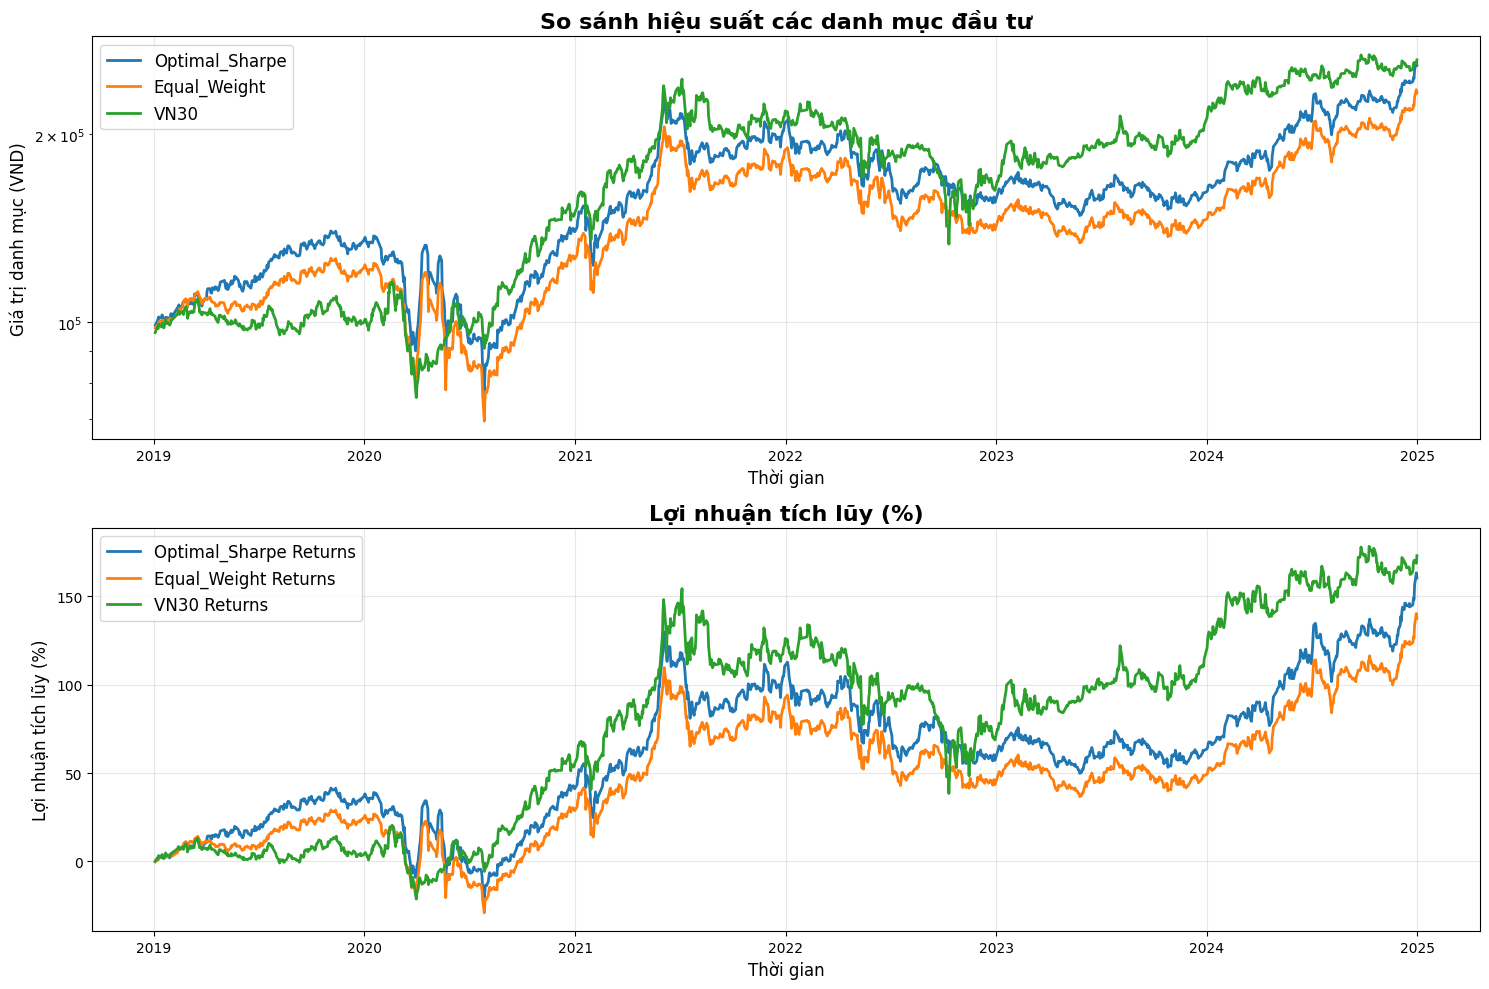

BẢNG SO SÁNH CHI TIẾT
                Total Return  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
Optimal_Sharpe        1.6031         0.1745             0.2654        0.5444       -0.4510
Equal_Weight          1.3752         0.1565             0.2634        0.4804       -0.4510
VN30                  1.7289         0.1838             0.2819        0.5458       -0.4555


In [32]:
# Vẽ biểu đồ
plt.figure(figsize=(15, 10))

# Biểu đồ chính - Giá trị danh mục theo thời gian
plt.subplot(2, 1, 1)
for column in results.columns:
    if len(results[column].dropna()) > 0:
        plt.plot(results.index, results[column], label=column, linewidth=2)

plt.title('So sánh hiệu suất các danh mục đầu tư', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá trị danh mục (VND)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Sử dụng thang logarit để dễ nhìn

# Biểu đồ phụ - Lợi nhuận tích lũy
plt.subplot(2, 1, 2)
for column in results.columns:
    if len(results[column].dropna()) > 0:
        cumulative_returns = (results[column] / results[column].iloc[0] - 1) * 100
        plt.plot(results.index, cumulative_returns, label=f'{column} Returns', linewidth=2)

plt.title('Lợi nhuận tích lũy (%)', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Lợi nhuận tích lũy (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tạo bảng so sánh
print("BẢNG SO SÁNH CHI TIẾT")
comparison_df = pd.DataFrame(metrics).T
comparison_df = comparison_df.round(4)
print(comparison_df.to_string())